In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import struct
import numpy as np




In [3]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [4]:

def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte'
                               % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape((len(labels),28,28))

    return images, labels

In [5]:
X_train, y_train = load_mnist('./data')
                              
X_test, y_test = load_mnist('./data',kind='t10k')
print(X_test.shape,y_test.shape)

(10000, 28, 28) (10000,)


In [6]:
def imgs_show_norm(imgs,row,col):
    fig,ax = plt.subplots(nrows=row,ncols=col,sharex=True,sharey=True)
    ax = ax.flatten()
    for i in range(row*col):
        img = imgs[i]
        min = np.min(img)
#         print('min = ',min)
        img = np.subtract(img,min) # 0->
        max = np.max(img)
#         print('max =',max)
        img = np.divide(img,max)
        
        ax[i].imshow(img,cmap='Greys', interpolation='nearest')
    
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()

In [7]:
def img_show_norm(img):
    min_ = np.min(img)
#     print('min = ',min_)
    img = np.subtract(img,min_) # 0->
    max_ = np.amax(a = img,keepdims=False)
#     print('max =',max_)
    img = np.divide(img,max_)  # 0->1
#     print(img)
    plt.figure(figsize=(1,1))
    plt.imshow(img,cmap='Greys',interpolation='nearest')

In [8]:
def img_show(img):
    plt.figure(figsize=(1,1))
    plt.imshow(img,cmap='Greys',interpolation='nearest')
    

In [9]:
def imgs_show(imgs,row,col):
    fig,ax = plt.subplots(nrows=row,ncols=col,sharex=True,sharey=True)
    ax = ax.flatten()
    for i in range(row*col):
        img = imgs[i]
        
        ax[i].imshow(img,cmap='Greys', interpolation='nearest')
    
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()
    
    

In [10]:
def normal_minist(img):
    return ((img / 255.0) -0.5)*2

In [11]:
def expend_HWC(img):
    return np.expand_dims(img,axis=3)


In [12]:
def to_CHW(img):
    return np.transpose(img,(0,3,1,2))
def to_HWC(img):
    return np.transpose(img,(0,2,3,1))

In [13]:
#只能运行一次
X_train_nor = expend_HWC(X_train)
X_train_nor = normal_minist(X_train_nor)
X_train_nor = to_CHW(X_train_nor)
print(X_train_nor.shape)

X_test_nor = expend_HWC(X_test)
X_test_nor = normal_minist(X_test_nor)
X_test_nor = to_CHW(X_test_nor)
print(X_test_nor.shape)




(60000, 1, 28, 28)
(10000, 1, 28, 28)


In [100]:
eval_index = [0,6]
negative_index = [1,2,3,4,5,7,8,9]
classes = 10
nn_index = [-1,1]
def compute_index_logical_equal(inputs,indexs):
    logic_result = (inputs==indexs[0])
    for value in indexs:
        logic_result = np.logical_or(inputs == value,logic_result)
    return logic_result

def compute_index_logical_not_equal(inputs,indexs):
    logic_result = (inputs==indexs[0])
    for value in indexs:
        logic_result = np.logical_or(inputs == value,logic_result)
    return np.logical_not(logic_result)

In [82]:
y_test_te = y_test[:10]
print(y_test_te)
print(compute_index_logical_equal(y_test_te,eval_index))
print(compute_index_logical_not_equal(y_test_te,eval_index))
print(y_test_te[compute_index_logical_equal(y_test_te,eval_index)])

[7 2 1 0 4 1 4 9 5 9]
[False False False  True False False False False False False]
[ True  True  True False  True  True  True  True  True  True]
[0]


test_postitive_lable :  (1938,) [0 0 6 0 6 6 0 0 6 6 0 6 0 0 6 6 6 6 6 0 6 0 6 6 0 6 6 0 6 0 6 6 0 0 0 0 6
 6 0 6 0 6 0 0 6 0 0 0 0 0]
test_nagivate_lable :  (8062,) [7 2 1 4 1 4 9 5 9 9 1 5 9 7 3 4 9 5 4 7 4 1 3 1 3 4 7 2 7 1 2 1 1 7 4 2 3
 5 1 2 4 4 3 5 5 4 1 9 5 7]


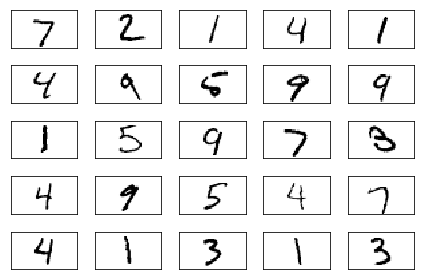

In [86]:
#init test data set
y_test_equal_evla_index = compute_index_logical_equal(y_test,eval_index)
y_test_no_equal_evla_index = compute_index_logical_not_equal(y_test,eval_index)

test_nagivate_lable = y_test[y_test_no_equal_evla_index]
test_nagivate = X_test_nor[y_test_no_equal_evla_index]

test_postitive = X_test_nor[y_test_equal_evla_index]
test_postitive_lable = y_test[y_test_equal_evla_index]
# print(test_postitive[:50])
print("test_postitive_lable : ",test_postitive_lable.shape,test_postitive_lable[:50])
print("test_nagivate_lable : ",test_nagivate_lable.shape,test_nagivate_lable[:50])
imgs_show(np.squeeze(test_nagivate[:25]),5,5)



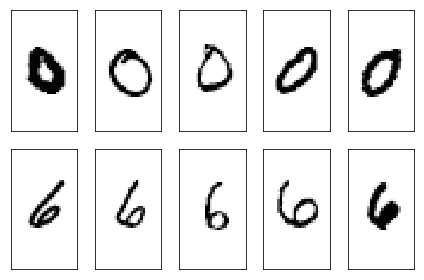

[0 0 0 0 0 6 6 6 6 6]


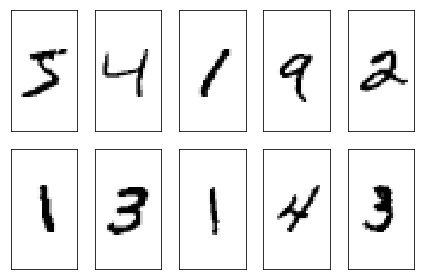

[5 4 1 9 2 1 3 1 4 3]
(48159, 1, 28, 28)


In [94]:
#init train data set
train_positive = []
label_positive =[]
for value in eval_index :
    
    shuffle_index_positive = np.random.permutation(len(X_train_nor[y_train == value]))
    train_positive.append(X_train_nor[y_train == value][shuffle_index_positive][:5])
    label_positive.append(y_train[y_train == value][shuffle_index_positive][:5])
train_positive = np.concatenate(train_positive)
label_positive = np.concatenate(label_positive)

imgs_show(np.squeeze(train_positive),2,5)
print(label_positive)


train_nagivate = X_train_nor[compute_index_logical_not_equal(y_train ,eval_index)]
label_nagivate = y_train[compute_index_logical_not_equal(y_train , eval_index)]
imgs_show(np.squeeze(train_nagivate[:10]),2,5)
print(label_nagivate[:10])
print(train_nagivate.shape)




In [ ]:
def compute_index_logical_equal(inputs,indexs):
    logic_result = (inputs==indexs[0])
    for value in indexs:
        logic_result = np.logical_or(inputs == value,logic_result)
    return logic_result


In [186]:
class AutoCodeNet(nn.Module):
    def __init__(self):
        super(AutoCodeNet,self).__init__()
        self.conv1 = nn.Conv2d(1,8,kernel_size=3,stride=2,padding=1)
#         self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(8,16,kernel_size=3,stride=2,padding=1)
#         self.pool2 = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(16,24,kernel_size=3,stride=2,padding=1)
#         self.pool3 = nn.MaxPool2d(2,2,padding=1)

        self.fc1 = nn.Linear(24*4*4,100)
        self.fc2 = nn.Linear(100,10)
      
            
        
        self.up1 = nn.Upsample(scale_factor = 2,mode='nearest')
#         F.interpolate()
        self.conv_d1 = nn.Conv2d(24,16,kernel_size=3,stride=1,padding=1)
        self.up2 = nn.Upsample(scale_factor = 2)
        self.conv_d2 = nn.Conv2d(16,8,kernel_size=3,stride=1)
        self.up3 = nn.Upsample(scale_factor = 2)
        self.conv_d3 = nn.Conv2d(8,8,kernel_size=3,stride=1,padding=1)
        
        self.conv_d4 = nn.Conv2d(8,1,kernel_size=3,stride=1,padding=1)
        
        self.features={}
        
    def decodeForward(self,x):
        #decode
        x = F.leaky_relu(self.conv1(x))
        self.features['relu1'] = x
        
        x = F.leaky_relu(self.conv2(x))
        self.features['relu2'] = x
        
        x = F.leaky_relu(self.conv3(x))
        self.features['relu3'] = x
        
        return x
    
    def encodeforward(self,x):
        
        x_g = self.up1(x)
        self.features['up1'] = x_g
        x_g = F.leaky_relu(self.conv_d1(x_g))
        self.features['relu_d1'] = x_g
        
        x_g = self.up2(x_g)
        self.features['up2'] = x_g
        x_g = F.leaky_relu(self.conv_d2(x_g))
        self.features['relu_d2'] = x_g
        
        x_g = self.up3(x_g)
        self.features['up3'] = x_g
        x_g = F.leaky_relu(self.conv_d3(x_g))
        self.features['relu_d3'] =x_g
        
        x_g = self.conv_d4(x_g)
        self.features['conv_d4'] = x_g
        
        x_g = F.tanh(x_g)
        self.features['tanh'] = x_g
        return  x_g
    
    def class_forward(self,x):
        x_c = x.view(-1,self.num_flat_features(x))
        x_c = F.leaky_relu(self.fc1(x_c))
        x_c = F.dropout(x_c, training=self.training)
        x_c = self.fc2(x_c)
        x_c = F.log_softmax(x_c,dim=1)
        return x_c
    
    def num_flat_features(self,x):
        size = x.size()[1:]
        num_features =1

        for s in size:
            num_features *= s
        return num_features
        
        
    def forward(self,x,label):
        assert len(x) % 3 == 0
        
        #decode
        x = self.decodeForward(x)
#         print('x.size(): ',x.size())

        
        
        positive_index = compute_index_logical_equal(label,eval_index)
        negitive_index = compute_index_logical_not_equal(label,eval_index)
        
        print("positive_index:",positive_index)
        print("negitive_index:",negitive_index)
        x_negative = x[negitive_index]
        y_negative = label[negitive_index]
        print('y_negative = ',y_negative)
        sorted_y, indices_y = torch.sort(y_negative)
        print('indices_y = ',indices_y)
        print('y_negative[indices_y] = ',y_negative[indices_y])
        if not isinstance(label,torch.Tensor) :
            label = torch.from_numpy(label)
            
        #sample
        self.g = torch.zeros_like(x[positive_index]) #require_grad = False
        
        print('g.size: ',self.g.size())
        p = np.random.uniform(0.45,0.65)
        q = np.random.randint(0,2)
        
        for i in range(len(self.g)):
            self.g[i] = x[positive_index][i] + nn_index[q] * p * (x[indices_y][2 * i] - x[indices_y][ 2 * i+1])
            print('y_negative[2 * i]:',y_negative[indices_y][2 * i],y_negative[indices_y][2 * i+1])
            
            
            
        
        #class
        x_c = self.class_forward(x)
        
        #encode
        with torch.no_grad():
            x_g = self.encodeforward(self.g)
        
        x_g_c = self.decodeForward(x_g)
        x_g_c = self.class_forward(x_g_c)
#         print("x_c : shape = ",x_c.size())
#         print("x_g_c : shape = ",x_g_c.size())
#         print("self.conv_d1 grad:",self.conv_d1.weight.grad)
#         print("self.conv_1 grad:",self.conv1.weight.grad[])
#         x_c = torch.cat(x_c,x_g_c)
        
        return x_g ,x_c,x_g_c
        
        
        
        
        
        
        

In [188]:
net_auto = AutoCodeNet()
# print(net_auto)
inp1 = Variable(torch.randn((30,1,28,28)))

out1,classs,_ = net_auto(inp1,torch.from_numpy( np.array([0,0,0,0,0,1,5,5,1,2,2,2,8,2,3,3,4,4,6,6,6,6,7,7,8,6,9,9,3,3])))
print(net_auto.conv1.weight.data.size())
classs = torch.sum(classs)
classs.backward()
print("net_auto.conv_d1 grad:",net_auto.conv_d1.weight.grad)
print("net_auto.conv_1 grad:",net_auto.conv1.weight.grad)
# print(out1.size())
# print(classs.size())

# print("decode:")
# print(net_auto.features['relu1'].size())
# # print(net_auto.features['pool1'].size())
# print(net_auto.features['relu2'].size())
# # print(net_auto.features['pool2'].size())
# print(net_auto.features['relu3'].size())
# # print(net_auto.features['pool3'].size())

# print("encode:")
# print(net_auto.features['up1'].size())
# print(net_auto.features['relu_d1'].size())
# print(net_auto.features['up2'].size())
# print(net_auto.features['relu_d2'].size())
# print(net_auto.features['up3'].size())
# print(net_auto.features['relu_d3'].size())
# print(net_auto.features['conv_d4'].size())
# print(net_auto.features['tanh'].size())



positive_index: tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
        0, 1, 0, 0, 0, 0], dtype=torch.uint8)
negitive_index: tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
        1, 0, 1, 1, 1, 1], dtype=torch.uint8)
y_negative =  tensor([1, 5, 5, 1, 2, 2, 2, 8, 2, 3, 3, 4, 4, 7, 7, 8, 9, 9, 3, 3])
indices_y =  tensor([ 0,  3,  8,  4,  5,  6, 18, 10,  9, 19, 11, 12,  2,  1, 13, 14,  7, 15,
        16, 17])
y_negative[indices_y] =  tensor([1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 5, 5, 7, 7, 8, 8, 9, 9])
g.size:  torch.Size([10, 24, 4, 4])
y_negative[2 * i]: tensor(1) tensor(1)
y_negative[2 * i]: tensor(2) tensor(2)
y_negative[2 * i]: tensor(2) tensor(2)
y_negative[2 * i]: tensor(3) tensor(3)
y_negative[2 * i]: tensor(3) tensor(3)
y_negative[2 * i]: tensor(4) tensor(4)
y_negative[2 * i]: tensor(5) tensor(5)
y_negative[2 * i]: tensor(7) tensor(7)
y_negative[2 * i]: tensor(8) tensor(8)
y_negative[2 * i]: tensor(9) tensor(9)
tor

In [189]:
def getnext(train_x,train_y,batch_size):
    batchs = len(train_y) // batch_size
    print(len(train_y),batchs)

    for i in range(batchs):
        x = train_x[batch_size * i : batch_size * (i+1)]
        y = train_y[batch_size * i : batch_size * (i+1)]
        yield x,y
        

In [26]:
def get_nagivate_next(train_positive,train_nagivate):
    batch_size = len(train_positive) 
    batchs = len(train_nagivate) // batch_size
    print(len(train_nagivate),batchs)
    
    for i in range(batchs):
        x = np.concatenate((train_positive,train_nagivate[batch_size * i : batch_size * (i+1)]))
        y = np.concatenate((np.zeros(batch_size),np.ones(batch_size)))
        shuf_index = np.random.permutation(len(y))
        x = x[shuf_index]
        y = y[shuf_index]
        
        
        yield x ,y 
        

In [27]:
def get_nagivate_batch_next(train_positive,train_nagivate,batch_size):
#     batch_size = len(train_positive) 
    batchs = len(train_nagivate) // batch_size
    print(len(train_nagivate),batchs)
    
    for i in range(batchs):
        x = np.concatenate((train_positive,train_nagivate[batch_size * i : batch_size * (i+1)]))
        y = np.concatenate((np.zeros(len(train_positive)),np.ones(len(train_nagivate))))
        shuf_index = np.random.permutation(len(x))
        x = x[shuf_index]
        y = y[shuf_index]
        
        
        yield x ,y 

In [28]:
def get_next_posi_nag(train_positive,train_nagivate,label_positive, label_nagivate ,batch_size):
#     batch_size = len(train_positive) 
    batchs = len(train_nagivate) // batch_size
    print(len(train_nagivate),batchs)
    
    for i in range(batchs):
        x = np.concatenate((train_positive,train_nagivate[batch_size * i : batch_size * (i+1)]))
        y = np.concatenate((label_positive,label_nagivate[batch_size * i : batch_size * (i+1)]))
        shuf_index = np.random.permutation(len(x))
        x = x[shuf_index]
        y = y[shuf_index]
        
        
        yield x ,y 

In [102]:
def get_next_pn_label(train_positive,train_nagivate,label_positive, label_nagivate):

    class_index_num =[]
    for i in range(1,10):
        class_index_num.append(len(train_nagivate[label_nagivate == i]))
    class_index_num = np.array(class_index_num)
    print('class_index_num = ',class_index_num)
    min_index_num = np.min(class_index_num)
    print('min_index_num = ',min_index_num)
    max_index_num = np.max(class_index_num)
    print('max_index_num = ',max_index_num)
    max_index_class = np.argmax(class_index_num) + 1
    print('max_index_class = ',max_index_class)
    batch_size = 2
    batchs = min_index_num // batch_size
    print('batchs = ',batchs)
    
    
    
    
    
    for i in range(batchs):
        x = train_positive
        y = label_positive
        for class_index in range(1,10):
            
            # batch_index < class len
            if batch_size * (i+1) <= class_index_num[class_index - 1] :
                
                x = np.concatenate( (x,train_nagivate[label_nagivate == class_index][batch_size * i : batch_size * (i+1)]))
                y = np.concatenate((y,label_nagivate[label_nagivate == class_index][batch_size * i : batch_size * (i+1)]))
        
        if len(x) < (3 * len(train_positive)) :
            x = np.concatenate((x,train_nagivate[label_nagivate == max_index_class][batch_size * (i+1) : batch_size * (i+2)]))
            y = np.concatenate((y,label_nagivate[label_nagivate == max_index_class][batch_size * (i+1) : batch_size * (i+2)]))

        shuf_index = np.random.permutation(len(x))
        x = x[shuf_index]
        y = y[shuf_index]
        
        
        yield x,y 


In [163]:
def get_next_pn_label2(train_positive,train_nagivate,label_positive, label_nagivate):

    class_index_num =[]
    for value in negative_index:
        class_index_num.append(len(train_nagivate[label_nagivate == value]))
    
    class_index_num = np.array(class_index_num)
    # class_index_num = np.sort(class_index_num)
    print('class_index_num = ',class_index_num)
    
    sort_index_num = np.argsort(class_index_num)
    print('sort_index_num = ',sort_index_num)
    
    min_index_num = class_index_num[sort_index_num[0]]
    max_index_num = class_index_num[sort_index_num[-1]]
    print('min_index_num = ',min_index_num)
    print('max_index_num = ',max_index_num)
    
    max_index_class = negative_index[sort_index_num[-1]]
    max_second_index_class = negative_index[sort_index_num[-2]]
    print('max_index_class = ',max_index_class)
    print('max_second_index_class = ',max_second_index_class)
    
    batch_size = 2
    batchs = min_index_num // batch_size
    print('batchs = ',batchs)
    
    
    
    for i in range(batchs):
        x = []
        y = []
        x.append(train_positive)  
        y.append(label_positive)
        
        for sor_index in sort_index_num :
                class_index = negative_index[sor_index]
#                 print(class_index)
                x.append(train_nagivate[label_nagivate == class_index][batch_size * i : batch_size * (i+1)])
                y.append(label_nagivate[label_nagivate == class_index][batch_size * i : batch_size * (i+1)])
        
        
        x.append(train_nagivate[label_nagivate == max_index_class][-(batch_size * (i+2)):-(batch_size * (i+1)) ])
        y.append(label_nagivate[label_nagivate == max_index_class][-(batch_size * (i+2)):-(batch_size * (i+1)) ])
#         print(label_nagivate[(-batch_size * (i+2)):-2])
        x.append(train_nagivate[label_nagivate == max_second_index_class][-(batch_size * (i+2)):-(batch_size * (i+1)) ])
        y.append(label_nagivate[label_nagivate == max_second_index_class][-(batch_size * (i+2)):-(batch_size * (i+1)) ])
        
#         for i in range(len(x)):
#             print(x[i].shape)
        x = np.concatenate(x)
        y = np.concatenate(y)
        shuf_index = np.random.permutation(len(x))
        x = x[shuf_index]
        y = y[shuf_index]
        
        
        yield x,y 

In [164]:
#     train_1 = train_nagivate[y_train == 1]
#     print("train_1.shape = ",train_1.shape)

#     train_2 = train_nagivate[y_train == 2]
#     print("train_2.shape = ",train_2.shape)

#     train_3 = train_nagivate[y_train == 3]
#     print("train_3.shape = ",train_3.shape)

#     train_4 = train_nagivate[y_train == 4]
#     print("train_0.shape = ",train_4.shape)


#     train_5 = train_nagivate[y_train == 5]
#     print("train_0.shape = ",train_5.shape)


#     train_6 = train_nagivate[y_train == 6]
#     print("train_6.shape = ",train_6.shape)

#     train_7 = train_nagivate[y_train == 7]
#     print("train_7.shape = ",train_7.shape)


#     train_8 = train_nagivate[y_train == 8]
#     print("train_8.shape = ",train_8.shape)


#     train_9 = train_nagivate[y_train == 9]
#     print("train_9.shape = ",train_9.shape)
                               
# train_0.shape =  (5923, 1, 28, 28)
# train_1.shape =  (6742, 1, 28, 28)
# train_2.shape =  (5958, 1, 28, 28)
# train_3.shape =  (6131, 1, 28, 28)
# train_4.shape =  (5842, 1, 28, 28)
# train_5.shape =  (5421, 1, 28, 28)
# train_6.shape =  (5918, 1, 28, 28)
# train_7.shape =  (6265, 1, 28, 28)
# train_8.shape =  (5851, 1, 28, 28)
# train_9.shape =  (5949, 1, 28, 28)

class_index_num =  [13 12 13 12 11 12 10 17]
sort_index_num =  [6 4 1 3 5 0 2 7]
min_index_num =  10
max_index_num =  17
max_index_class =  9
max_second_index_class =  3
batchs =  5
(30, 1, 28, 28)
[8 6 3 0 3 9 0 0 7 6 9 0 6 9 1 4 5 3 6 4 0 2 3 8 1 5 9 2 7 6]


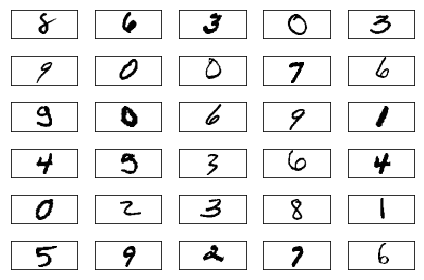

(30, 1, 28, 28)
[5 0 6 6 6 9 1 3 3 2 0 9 4 4 0 1 2 6 8 6 7 3 7 9 5 3 0 9 8 0]


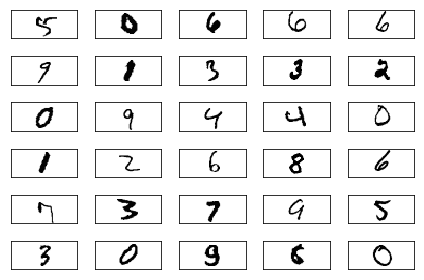

(30, 1, 28, 28)
[9 8 6 3 1 2 1 0 7 5 2 4 8 6 7 6 6 0 9 5 9 6 0 3 0 3 3 0 4 9]


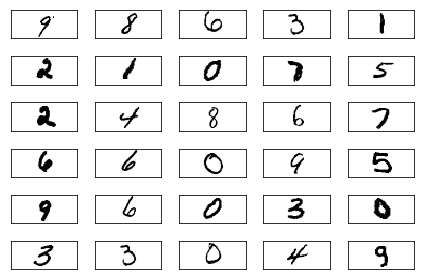

(30, 1, 28, 28)
[8 8 2 6 6 9 3 7 0 9 4 7 6 1 9 0 0 3 6 4 3 5 6 5 9 2 3 0 0 1]


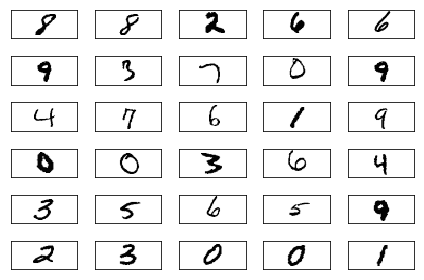

(30, 1, 28, 28)
[2 1 1 9 5 4 3 3 7 3 2 0 9 0 0 6 6 6 5 8 6 9 8 0 9 4 7 0 6 3]


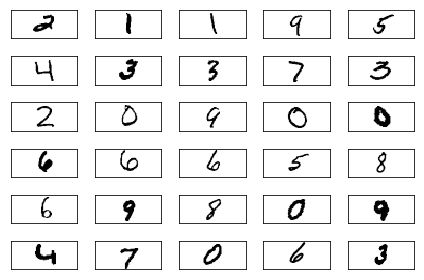

In [166]:
datas = get_next_pn_label2(train_positive,train_nagivate[1100:1200],label_positive,label_nagivate[1100:1200])
for x,y in datas:
    print(x.shape)
    
    print(y)
    imgs_show(np.squeeze( x),6,5)


In [33]:
net_auto = AutoCodeNet()
net_auto.load_state_dict(torch.load('model_asociate_learning_simple5.pt'))

In [37]:

# net_auto = torch.load('model_autoEncode5.pkl')
use_cuda = torch.cuda.is_available()
torch.manual_seed(666)
device = torch.device("cuda" if use_cuda else "cpu")
net_auto.to(device)
net_auto.float()


criterion = nn.MSELoss()
optimizer = optim.SGD(net_auto.parameters(),lr=0.0001,momentum=0.9,weight_decay=5e-4)


In [ ]:
#X_train_nor


for epoch in range(10):
    #train:
    
    shuf_nagivate = np.random.permutation(len(train_nagivate))
    train_nagivate = train_nagivate[shuf_nagivate]
    label_nagivate = label_nagivate[shuf_nagivate]
#     datas = get_next_posi_nag(train_positive,train_nagivate,label_positive,label_nagivate, 10)
    datas = get_next_pn_label(train_positive,train_nagivate,label_positive,label_nagivate)
    
    trainloss_g = 0
    trainloss_c = 0
    
    for x,y in datas:
        inputs ,lables,lables_2 = torch.from_numpy(x).float().to(device),\
            torch.from_numpy(y).long().to(device),\
            torch.from_numpy(label_positive).long().to(device)
#         print(inputs.size())
#         print(lables[0])
        optimizer.zero_grad()
        output,classify,classify2 = net_auto(inputs,lables)
#         print(output.size())
#         print(classify.size())
#         loss_g = criterion(output,inputs) 
        loss_c = F.nll_loss(classify,lables)
        loss_c2 = F.nll_loss(classify2,lables_2)
        loss = loss_c + loss_c2
        print('loss_c = %.4f,loss_c2 =%.4f'%(loss_c,loss_c2))
        trainloss_g += loss_c2.item()
        trainloss_c += loss_c.item()
        loss.backward()
#         print("net_auto.conv_d1 grad:",net_auto.conv_d1.weight.grad)
        
#         print("after net_auto.conv_1 grad:",net_auto.conv1.weight.grad)
        optimizer.step()
        
    print('%d  gloss: %.3f, class loss:%.3f' % (epoch ,  trainloss_g,trainloss_c))
    
    
    torch.save(net_auto.state_dict(),'model_asociate_learning_simple'+str(epoch)+'.pt')
    


class_index_num =  [6742 5958 6131 5842 5421 5918 6265 5851 5949]
min_index_num =  5421
max_index_num =  6742
max_index_class =  1
batchs =  2710
loss_c = 0.0023,loss_c2 =0.0007
loss_c = 0.0003,loss_c2 =0.0000
loss_c = 0.0008,loss_c2 =0.0000
loss_c = 0.0013,loss_c2 =0.0000
loss_c = 0.0108,loss_c2 =0.0000
loss_c = 0.0043,loss_c2 =0.0000
loss_c = 0.0006,loss_c2 =0.0000
loss_c = 0.0004,loss_c2 =0.0000
loss_c = 0.0200,loss_c2 =0.0000
loss_c = 0.0532,loss_c2 =0.0000
loss_c = 0.0019,loss_c2 =0.0006
loss_c = 0.0018,loss_c2 =0.0000
loss_c = 0.0018,loss_c2 =0.0000
loss_c = 0.0015,loss_c2 =0.0005
loss_c = 0.0273,loss_c2 =0.0045
loss_c = 0.0065,loss_c2 =0.0789
loss_c = 0.0026,loss_c2 =0.0002
loss_c = 0.0401,loss_c2 =0.0001
loss_c = 0.0015,loss_c2 =0.0000
loss_c = 0.0320,loss_c2 =0.0000
loss_c = 0.0147,loss_c2 =0.0000
loss_c = 0.0035,loss_c2 =0.0000
loss_c = 0.0211,loss_c2 =0.0000
loss_c = 0.0076,loss_c2 =0.0000
loss_c = 0.0328,loss_c2 =0.0000
loss_c = 0.0065,loss_c2 =0.0006
loss_c = 0.0143,loss_c

loss_c = 0.0070,loss_c2 =0.0000
loss_c = 0.1076,loss_c2 =0.0000
loss_c = 0.0048,loss_c2 =0.0000
loss_c = 0.0026,loss_c2 =0.0000
loss_c = 0.0609,loss_c2 =0.0000
loss_c = 0.0105,loss_c2 =0.0000
loss_c = 0.0403,loss_c2 =0.0007
loss_c = 0.0056,loss_c2 =0.0040
loss_c = 0.0018,loss_c2 =0.0001
loss_c = 0.0050,loss_c2 =0.0001
loss_c = 0.0009,loss_c2 =0.0001
loss_c = 0.0135,loss_c2 =0.0000
loss_c = 0.0021,loss_c2 =0.0002
loss_c = 0.0007,loss_c2 =0.0037
loss_c = 0.0101,loss_c2 =0.0002
loss_c = 0.0007,loss_c2 =0.0000
loss_c = 0.0167,loss_c2 =0.0006
loss_c = 0.0213,loss_c2 =0.0000
loss_c = 0.0095,loss_c2 =0.0004
loss_c = 0.0054,loss_c2 =0.0004
loss_c = 0.0013,loss_c2 =0.0000
loss_c = 0.0057,loss_c2 =0.0000
loss_c = 0.0030,loss_c2 =0.0000
loss_c = 0.0017,loss_c2 =0.0000
loss_c = 0.0058,loss_c2 =0.0000
loss_c = 0.0551,loss_c2 =0.0000
loss_c = 0.0012,loss_c2 =0.0001
loss_c = 0.0070,loss_c2 =0.0002
loss_c = 0.0010,loss_c2 =0.0045
loss_c = 0.1260,loss_c2 =0.0000
loss_c = 0.0014,loss_c2 =0.0000
loss_c =

loss_c = 0.0346,loss_c2 =0.0000
loss_c = 0.1093,loss_c2 =0.0008
loss_c = 0.0038,loss_c2 =0.0001
loss_c = 0.0008,loss_c2 =0.0000
loss_c = 0.0317,loss_c2 =0.0001
loss_c = 0.0023,loss_c2 =0.0000
loss_c = 0.0006,loss_c2 =0.0002
loss_c = 0.0153,loss_c2 =0.0000
loss_c = 0.0012,loss_c2 =0.0003
loss_c = 0.0054,loss_c2 =0.0001
loss_c = 0.0017,loss_c2 =0.0000
loss_c = 0.0162,loss_c2 =0.0000
loss_c = 0.0095,loss_c2 =0.0082
loss_c = 0.0034,loss_c2 =0.0000
loss_c = 0.0072,loss_c2 =0.0000
loss_c = 0.0107,loss_c2 =0.0000
loss_c = 0.0073,loss_c2 =0.0000
loss_c = 0.0112,loss_c2 =0.0000
loss_c = 0.0080,loss_c2 =0.0003
loss_c = 0.0318,loss_c2 =0.0002
loss_c = 0.0017,loss_c2 =0.0001
loss_c = 0.0148,loss_c2 =0.0000
loss_c = 0.0002,loss_c2 =0.0000
loss_c = 0.0488,loss_c2 =0.0006
loss_c = 0.0005,loss_c2 =0.0000
loss_c = 0.0191,loss_c2 =0.0003
loss_c = 0.0176,loss_c2 =0.0008
loss_c = 0.0028,loss_c2 =0.0000
loss_c = 0.0171,loss_c2 =0.0000
loss_c = 0.0034,loss_c2 =0.0022
loss_c = 0.0302,loss_c2 =0.0000
loss_c =

loss_c = 0.0170,loss_c2 =0.0000
loss_c = 0.0106,loss_c2 =0.0000
loss_c = 0.0829,loss_c2 =0.0000
loss_c = 0.0082,loss_c2 =0.0000
loss_c = 0.0145,loss_c2 =0.0000
loss_c = 0.0258,loss_c2 =0.0000
loss_c = 0.0169,loss_c2 =0.0000
loss_c = 0.0016,loss_c2 =0.0006
loss_c = 0.0025,loss_c2 =0.0003
loss_c = 0.0038,loss_c2 =0.0000
loss_c = 0.0008,loss_c2 =0.0000
loss_c = 0.0014,loss_c2 =0.0000
loss_c = 0.0250,loss_c2 =0.0000
loss_c = 0.0041,loss_c2 =0.0008
loss_c = 0.0016,loss_c2 =0.0000
loss_c = 0.0062,loss_c2 =0.0000
loss_c = 0.0132,loss_c2 =0.0001
loss_c = 0.0051,loss_c2 =0.0000
loss_c = 0.0279,loss_c2 =0.0044
loss_c = 0.0099,loss_c2 =0.0009
loss_c = 0.0055,loss_c2 =0.0000
loss_c = 0.0058,loss_c2 =0.0000
loss_c = 0.0008,loss_c2 =0.0001
loss_c = 0.0014,loss_c2 =0.0000
loss_c = 0.0059,loss_c2 =0.0000
loss_c = 0.0108,loss_c2 =0.0000
loss_c = 0.0018,loss_c2 =0.0000
loss_c = 0.0009,loss_c2 =0.0000
loss_c = 0.0010,loss_c2 =0.0001
loss_c = 0.0363,loss_c2 =0.0150
loss_c = 0.0033,loss_c2 =0.0026
loss_c =

loss_c = 0.0200,loss_c2 =0.0023
loss_c = 0.0029,loss_c2 =0.0003
loss_c = 0.0041,loss_c2 =0.0000
loss_c = 0.0040,loss_c2 =0.0000
loss_c = 0.0120,loss_c2 =0.0000
loss_c = 0.0060,loss_c2 =0.0000
loss_c = 0.0034,loss_c2 =0.0000
loss_c = 0.0375,loss_c2 =0.0009
loss_c = 0.0054,loss_c2 =0.0002
loss_c = 0.0037,loss_c2 =0.0004
loss_c = 0.0038,loss_c2 =0.0093
loss_c = 0.0100,loss_c2 =0.2848
loss_c = 0.0030,loss_c2 =0.0000
loss_c = 0.0013,loss_c2 =0.0000
loss_c = 0.0078,loss_c2 =0.0000
loss_c = 0.0082,loss_c2 =0.0000
loss_c = 0.0019,loss_c2 =0.0000
loss_c = 0.0272,loss_c2 =0.0046
loss_c = 0.0029,loss_c2 =0.0000
loss_c = 0.0103,loss_c2 =0.0001
loss_c = 0.0039,loss_c2 =0.0000
loss_c = 0.0016,loss_c2 =0.0000
loss_c = 0.0005,loss_c2 =0.0000
loss_c = 0.0091,loss_c2 =0.0008
loss_c = 0.0046,loss_c2 =0.0000
loss_c = 0.0034,loss_c2 =0.0000
loss_c = 0.0082,loss_c2 =0.0006
loss_c = 0.0007,loss_c2 =0.0000
loss_c = 0.0052,loss_c2 =0.0021
loss_c = 0.0019,loss_c2 =0.0000
loss_c = 0.0152,loss_c2 =0.0007
loss_c =

loss_c = 0.0085,loss_c2 =0.0000
loss_c = 0.0075,loss_c2 =0.0000
loss_c = 0.0056,loss_c2 =0.0000
loss_c = 0.0174,loss_c2 =0.0004
loss_c = 0.0014,loss_c2 =0.0000
loss_c = 0.0042,loss_c2 =0.0000
loss_c = 0.0761,loss_c2 =0.0337
loss_c = 0.0003,loss_c2 =0.0000
loss_c = 0.0048,loss_c2 =0.0001
loss_c = 0.0123,loss_c2 =0.0000
loss_c = 0.0344,loss_c2 =0.0000
loss_c = 0.0052,loss_c2 =0.0000
loss_c = 0.0112,loss_c2 =0.0000
loss_c = 0.0027,loss_c2 =0.0000
loss_c = 0.0024,loss_c2 =0.0001
loss_c = 0.0070,loss_c2 =0.0000
loss_c = 0.0017,loss_c2 =0.0000
loss_c = 0.0031,loss_c2 =0.0000
loss_c = 0.0011,loss_c2 =0.0000
loss_c = 0.0011,loss_c2 =0.0002
loss_c = 0.0058,loss_c2 =0.0001
loss_c = 0.0597,loss_c2 =0.0025
loss_c = 0.0123,loss_c2 =0.0000
loss_c = 0.0192,loss_c2 =0.0000
loss_c = 0.0159,loss_c2 =0.0000
loss_c = 0.0025,loss_c2 =0.0000
loss_c = 0.0029,loss_c2 =0.0002
loss_c = 0.0069,loss_c2 =0.0000
loss_c = 0.0023,loss_c2 =0.0000
loss_c = 0.0007,loss_c2 =0.0000
loss_c = 0.0048,loss_c2 =0.0005
loss_c =

loss_c = 0.0003,loss_c2 =0.0001
loss_c = 0.0302,loss_c2 =0.0000
loss_c = 0.0124,loss_c2 =0.0084
loss_c = 0.0008,loss_c2 =0.0000
loss_c = 0.0042,loss_c2 =0.0001
loss_c = 0.0296,loss_c2 =0.0001
loss_c = 0.0163,loss_c2 =0.0000
loss_c = 0.0011,loss_c2 =0.0000
loss_c = 0.1517,loss_c2 =0.0004
loss_c = 0.0102,loss_c2 =0.0000
loss_c = 0.0232,loss_c2 =0.0000
loss_c = 0.0112,loss_c2 =0.0001
loss_c = 0.0048,loss_c2 =0.0000
loss_c = 0.0013,loss_c2 =0.0000
loss_c = 0.0024,loss_c2 =0.0000
loss_c = 0.0116,loss_c2 =0.0000
loss_c = 0.0126,loss_c2 =0.0002
loss_c = 0.0012,loss_c2 =0.0001
loss_c = 0.0023,loss_c2 =0.0001
loss_c = 0.0038,loss_c2 =0.0000
loss_c = 0.0075,loss_c2 =0.0002
loss_c = 0.0643,loss_c2 =0.0000
loss_c = 0.0031,loss_c2 =0.0003
loss_c = 0.0155,loss_c2 =0.0001
loss_c = 0.0606,loss_c2 =0.0000
loss_c = 0.0116,loss_c2 =0.0001
loss_c = 0.0049,loss_c2 =0.0000
loss_c = 0.0162,loss_c2 =0.0000
loss_c = 0.0005,loss_c2 =0.0000
loss_c = 0.0631,loss_c2 =0.0002
loss_c = 0.0181,loss_c2 =0.0000
loss_c =

loss_c = 0.0883,loss_c2 =0.0000
loss_c = 0.0178,loss_c2 =0.0000
loss_c = 0.0130,loss_c2 =0.0002
loss_c = 0.0025,loss_c2 =0.0000
loss_c = 0.0015,loss_c2 =0.0003
loss_c = 0.0026,loss_c2 =0.0000
loss_c = 0.0329,loss_c2 =0.0000
loss_c = 0.0495,loss_c2 =0.0000
loss_c = 0.0022,loss_c2 =0.0002
loss_c = 0.0014,loss_c2 =0.0000
loss_c = 0.0053,loss_c2 =0.0013
loss_c = 0.0124,loss_c2 =0.0000
loss_c = 0.0017,loss_c2 =0.0000
loss_c = 0.0754,loss_c2 =0.0000
loss_c = 0.0345,loss_c2 =0.0009
loss_c = 0.0050,loss_c2 =0.0002
loss_c = 0.0077,loss_c2 =0.0001
loss_c = 0.0050,loss_c2 =0.0001
loss_c = 0.0032,loss_c2 =0.0000
loss_c = 0.0020,loss_c2 =0.0003
loss_c = 0.0124,loss_c2 =0.0000
loss_c = 0.0075,loss_c2 =0.0000
loss_c = 0.0005,loss_c2 =0.0000
loss_c = 0.0012,loss_c2 =0.0000
loss_c = 0.0011,loss_c2 =0.0000
loss_c = 0.0020,loss_c2 =0.0000
loss_c = 0.0009,loss_c2 =0.0000
loss_c = 0.0028,loss_c2 =0.0001
loss_c = 0.0220,loss_c2 =0.0000
loss_c = 0.0016,loss_c2 =0.0000
loss_c = 0.0050,loss_c2 =0.0000
loss_c =

loss_c = 0.0039,loss_c2 =0.0003
loss_c = 0.0006,loss_c2 =0.0001
loss_c = 0.0044,loss_c2 =0.0000
loss_c = 0.0048,loss_c2 =0.0010
loss_c = 0.0005,loss_c2 =0.0001
loss_c = 0.0013,loss_c2 =0.0298
loss_c = 0.0134,loss_c2 =0.0000
loss_c = 0.0777,loss_c2 =0.0000
loss_c = 0.0082,loss_c2 =0.0000
loss_c = 0.0613,loss_c2 =0.0051
loss_c = 0.0318,loss_c2 =0.0000
loss_c = 0.0043,loss_c2 =0.0000
loss_c = 0.0065,loss_c2 =0.0000
loss_c = 0.0051,loss_c2 =0.0000
loss_c = 0.0244,loss_c2 =0.0002
loss_c = 0.0079,loss_c2 =0.0000
loss_c = 0.0012,loss_c2 =0.0001
loss_c = 0.0044,loss_c2 =0.0000
loss_c = 0.0011,loss_c2 =0.0029
loss_c = 0.0136,loss_c2 =0.0112
loss_c = 0.0168,loss_c2 =0.0000
loss_c = 0.0040,loss_c2 =0.0000
loss_c = 0.0032,loss_c2 =0.0000
loss_c = 0.0087,loss_c2 =0.0000
loss_c = 0.0013,loss_c2 =0.0000
loss_c = 0.0860,loss_c2 =0.0000
loss_c = 0.0200,loss_c2 =0.0000
loss_c = 0.0006,loss_c2 =0.0000
loss_c = 0.0229,loss_c2 =0.0001
loss_c = 0.0022,loss_c2 =0.0000
loss_c = 0.0174,loss_c2 =0.0000
loss_c =

loss_c = 0.1376,loss_c2 =0.0044
loss_c = 0.0142,loss_c2 =0.0000
loss_c = 0.0029,loss_c2 =0.0000
loss_c = 0.0011,loss_c2 =0.0000
loss_c = 0.0049,loss_c2 =0.0000
loss_c = 0.0062,loss_c2 =0.0000
loss_c = 0.0017,loss_c2 =0.0012
loss_c = 0.0005,loss_c2 =0.0000
loss_c = 0.0415,loss_c2 =0.0000
loss_c = 0.0047,loss_c2 =0.0001
loss_c = 0.0010,loss_c2 =0.0004
loss_c = 0.0015,loss_c2 =0.0000
loss_c = 0.0032,loss_c2 =0.0000
loss_c = 0.0006,loss_c2 =0.0000
loss_c = 0.0625,loss_c2 =0.0000
loss_c = 0.0036,loss_c2 =0.0000
loss_c = 0.0154,loss_c2 =0.0001
loss_c = 0.0010,loss_c2 =0.0000
loss_c = 0.1304,loss_c2 =0.0000
loss_c = 0.0037,loss_c2 =0.0000
loss_c = 0.0051,loss_c2 =0.0000
loss_c = 0.0268,loss_c2 =0.0054
loss_c = 0.0126,loss_c2 =0.0018
loss_c = 0.0042,loss_c2 =0.0002
loss_c = 0.0007,loss_c2 =0.0000
loss_c = 0.0046,loss_c2 =0.0007
loss_c = 0.0159,loss_c2 =0.0000
loss_c = 0.0031,loss_c2 =0.0000
loss_c = 0.0135,loss_c2 =0.0001
loss_c = 0.0011,loss_c2 =0.0000
loss_c = 0.0022,loss_c2 =0.0035
loss_c =

loss_c = 0.0115,loss_c2 =0.0000
loss_c = 0.0011,loss_c2 =0.0001
loss_c = 0.0033,loss_c2 =0.0002
loss_c = 0.0029,loss_c2 =0.0001
loss_c = 0.0097,loss_c2 =0.0000
loss_c = 0.0197,loss_c2 =0.0000
loss_c = 0.0274,loss_c2 =0.0027
loss_c = 0.0057,loss_c2 =0.0001
loss_c = 0.0015,loss_c2 =0.0042
loss_c = 0.0015,loss_c2 =0.0000
loss_c = 0.0024,loss_c2 =0.0000
loss_c = 0.1154,loss_c2 =0.0000
loss_c = 0.0021,loss_c2 =0.0012
loss_c = 0.0044,loss_c2 =0.0000
loss_c = 0.0016,loss_c2 =0.0001
loss_c = 0.0024,loss_c2 =0.0000
loss_c = 0.0009,loss_c2 =0.0000
loss_c = 0.0064,loss_c2 =0.0000
loss_c = 0.0101,loss_c2 =0.0000
loss_c = 0.0522,loss_c2 =0.0000
loss_c = 0.0023,loss_c2 =0.0000
loss_c = 0.0294,loss_c2 =0.0000
loss_c = 0.0128,loss_c2 =0.0001
loss_c = 0.0015,loss_c2 =0.0031
loss_c = 0.0312,loss_c2 =0.0000
loss_c = 0.0233,loss_c2 =0.0000
loss_c = 0.0019,loss_c2 =0.0000
loss_c = 0.0028,loss_c2 =0.0000
loss_c = 0.0042,loss_c2 =0.0000
loss_c = 0.0061,loss_c2 =0.0000
loss_c = 0.0458,loss_c2 =0.0000
loss_c =

loss_c = 0.0022,loss_c2 =0.0000
loss_c = 0.0276,loss_c2 =0.0001
loss_c = 0.0016,loss_c2 =0.0000
loss_c = 0.0071,loss_c2 =0.0031
loss_c = 0.0242,loss_c2 =0.0000
loss_c = 0.0736,loss_c2 =0.0018
loss_c = 0.0428,loss_c2 =0.0000
loss_c = 0.0037,loss_c2 =0.0000
loss_c = 0.0209,loss_c2 =0.0013
loss_c = 0.0021,loss_c2 =0.0021
loss_c = 0.0024,loss_c2 =0.0000
loss_c = 0.0004,loss_c2 =0.0001
loss_c = 0.0027,loss_c2 =0.0002
loss_c = 0.0004,loss_c2 =0.0001
loss_c = 0.0022,loss_c2 =0.0000
loss_c = 0.0083,loss_c2 =0.0434
loss_c = 0.0024,loss_c2 =0.0000
loss_c = 0.0052,loss_c2 =0.0004
loss_c = 0.0088,loss_c2 =0.0000
loss_c = 0.0058,loss_c2 =0.0000
loss_c = 0.0009,loss_c2 =0.0000
loss_c = 0.0051,loss_c2 =0.0000
loss_c = 0.0353,loss_c2 =0.4913
loss_c = 0.0045,loss_c2 =0.0000
loss_c = 0.0466,loss_c2 =0.0000
loss_c = 0.0210,loss_c2 =0.0000
loss_c = 0.0376,loss_c2 =0.0002
loss_c = 0.0012,loss_c2 =0.0018
loss_c = 0.0011,loss_c2 =0.0000
loss_c = 0.0038,loss_c2 =0.0000
loss_c = 0.0352,loss_c2 =0.0000
loss_c =

loss_c = 0.0024,loss_c2 =0.0000
loss_c = 0.0027,loss_c2 =0.0001
loss_c = 0.0739,loss_c2 =0.0000
loss_c = 0.0003,loss_c2 =0.0001
loss_c = 0.0015,loss_c2 =0.0000
loss_c = 0.0004,loss_c2 =0.0000
loss_c = 0.0155,loss_c2 =0.0000
loss_c = 0.0061,loss_c2 =0.0000
loss_c = 0.0037,loss_c2 =0.0001
loss_c = 0.0063,loss_c2 =0.0000
loss_c = 0.0073,loss_c2 =0.0000
loss_c = 0.0017,loss_c2 =0.0000
loss_c = 0.0122,loss_c2 =0.0000
loss_c = 0.0101,loss_c2 =0.0003
loss_c = 0.0096,loss_c2 =0.0000
loss_c = 0.0021,loss_c2 =0.0000
loss_c = 0.0129,loss_c2 =0.0000
loss_c = 0.0032,loss_c2 =0.0000
loss_c = 0.0047,loss_c2 =0.0000
loss_c = 0.0206,loss_c2 =0.0005
loss_c = 0.0132,loss_c2 =0.0059
loss_c = 0.0018,loss_c2 =0.0001
loss_c = 0.0004,loss_c2 =0.0164
loss_c = 0.0017,loss_c2 =0.0000
loss_c = 0.0036,loss_c2 =0.0000
loss_c = 0.0020,loss_c2 =0.0009
loss_c = 0.0033,loss_c2 =0.0000
loss_c = 0.0027,loss_c2 =0.0000
loss_c = 0.0041,loss_c2 =0.0000
loss_c = 0.0659,loss_c2 =0.0004
loss_c = 0.0085,loss_c2 =0.0022
loss_c =

loss_c = 0.0113,loss_c2 =0.0000
loss_c = 0.0106,loss_c2 =0.0000
loss_c = 0.0016,loss_c2 =0.0000
loss_c = 0.0025,loss_c2 =0.0001
loss_c = 0.0119,loss_c2 =0.0010
loss_c = 0.0125,loss_c2 =0.0000
loss_c = 0.1276,loss_c2 =0.0000
loss_c = 0.1323,loss_c2 =0.0000
loss_c = 0.0009,loss_c2 =0.0002
loss_c = 0.0013,loss_c2 =0.0000
loss_c = 0.0148,loss_c2 =0.0000
loss_c = 0.0005,loss_c2 =0.0000
loss_c = 0.0287,loss_c2 =0.0000
loss_c = 0.0395,loss_c2 =0.0000
loss_c = 0.0020,loss_c2 =0.0000
loss_c = 0.0016,loss_c2 =0.0009
loss_c = 0.0060,loss_c2 =0.0008
loss_c = 0.0043,loss_c2 =0.0000
loss_c = 0.0050,loss_c2 =0.0000
loss_c = 0.0053,loss_c2 =0.0000
loss_c = 0.0098,loss_c2 =0.0003
loss_c = 0.0039,loss_c2 =0.0000
loss_c = 0.0100,loss_c2 =0.0000
loss_c = 0.0384,loss_c2 =0.0009
loss_c = 0.0054,loss_c2 =0.0004
loss_c = 0.0364,loss_c2 =0.0020
loss_c = 0.0595,loss_c2 =0.0002
loss_c = 0.0268,loss_c2 =0.0000
loss_c = 0.0007,loss_c2 =0.0000
loss_c = 0.0405,loss_c2 =0.0003
loss_c = 0.0099,loss_c2 =0.0131
loss_c =

loss_c = 0.0021,loss_c2 =0.0000
loss_c = 0.0074,loss_c2 =0.0001
loss_c = 0.0045,loss_c2 =0.0047
loss_c = 0.0097,loss_c2 =0.0000
loss_c = 0.0017,loss_c2 =0.0027
loss_c = 0.0018,loss_c2 =0.0001
loss_c = 0.0023,loss_c2 =0.0001
loss_c = 0.0022,loss_c2 =0.0000
loss_c = 0.0009,loss_c2 =0.0000
loss_c = 0.0015,loss_c2 =0.0001
loss_c = 0.0013,loss_c2 =0.0000
loss_c = 0.0168,loss_c2 =0.0012
loss_c = 0.0004,loss_c2 =0.0000
loss_c = 0.0059,loss_c2 =0.0000
loss_c = 0.0040,loss_c2 =0.0000
loss_c = 0.0009,loss_c2 =0.0000
loss_c = 0.0029,loss_c2 =0.0000
loss_c = 0.0012,loss_c2 =0.0001
loss_c = 0.0041,loss_c2 =0.0000
loss_c = 0.0125,loss_c2 =0.0023
loss_c = 0.0187,loss_c2 =0.0018
loss_c = 0.0099,loss_c2 =0.0722
loss_c = 0.0150,loss_c2 =0.0006
loss_c = 0.0033,loss_c2 =0.0000
loss_c = 0.0011,loss_c2 =0.0000
loss_c = 0.0049,loss_c2 =0.0002
loss_c = 0.0011,loss_c2 =0.0000
loss_c = 0.0033,loss_c2 =0.0000
loss_c = 0.0467,loss_c2 =0.0001
loss_c = 0.0192,loss_c2 =0.0000
loss_c = 0.0030,loss_c2 =0.0000
loss_c =

loss_c = 0.0117,loss_c2 =0.0000
loss_c = 0.0052,loss_c2 =0.0000
loss_c = 0.0006,loss_c2 =0.0000
loss_c = 0.0205,loss_c2 =0.0000
loss_c = 0.0052,loss_c2 =0.0000
loss_c = 0.0101,loss_c2 =0.0000
loss_c = 0.1348,loss_c2 =0.0000
loss_c = 0.0034,loss_c2 =0.0002
loss_c = 0.0019,loss_c2 =0.0001
loss_c = 0.0010,loss_c2 =0.0000
loss_c = 0.0202,loss_c2 =0.0000
loss_c = 0.0497,loss_c2 =0.0306
loss_c = 0.0019,loss_c2 =0.0002
loss_c = 0.0474,loss_c2 =0.0000
loss_c = 0.0044,loss_c2 =0.0000
loss_c = 0.0524,loss_c2 =0.0000
loss_c = 0.0096,loss_c2 =0.0002
loss_c = 0.0139,loss_c2 =0.0000
loss_c = 0.0450,loss_c2 =0.0035
loss_c = 0.0077,loss_c2 =0.0029
loss_c = 0.0153,loss_c2 =0.0001
loss_c = 0.0073,loss_c2 =0.0000
loss_c = 0.2405,loss_c2 =0.0003
loss_c = 0.0024,loss_c2 =0.0000
loss_c = 0.0009,loss_c2 =0.0001
loss_c = 0.0023,loss_c2 =0.0000
loss_c = 0.0064,loss_c2 =0.0000
loss_c = 0.0007,loss_c2 =0.0001
loss_c = 0.0010,loss_c2 =0.0004
loss_c = 0.0052,loss_c2 =0.0000
loss_c = 0.0539,loss_c2 =0.0000
loss_c =

loss_c = 0.0006,loss_c2 =0.0004
loss_c = 0.0016,loss_c2 =0.0000
loss_c = 0.0336,loss_c2 =0.0000
loss_c = 0.0433,loss_c2 =0.0000
loss_c = 0.0006,loss_c2 =0.0000
loss_c = 0.0038,loss_c2 =0.0000
loss_c = 0.0009,loss_c2 =0.0000
loss_c = 0.0035,loss_c2 =0.0000
loss_c = 0.0060,loss_c2 =0.0011
loss_c = 0.0002,loss_c2 =0.2369
loss_c = 0.0048,loss_c2 =0.0005
loss_c = 0.0013,loss_c2 =0.0000
loss_c = 0.0338,loss_c2 =0.0038
loss_c = 0.0007,loss_c2 =0.0000
loss_c = 0.0024,loss_c2 =0.0000
loss_c = 0.0052,loss_c2 =0.0000
loss_c = 0.0004,loss_c2 =0.0000
loss_c = 0.0050,loss_c2 =0.0003
loss_c = 0.0040,loss_c2 =0.0000
loss_c = 0.0034,loss_c2 =0.0649
loss_c = 0.0192,loss_c2 =0.0000
loss_c = 0.0040,loss_c2 =0.0001
loss_c = 0.0096,loss_c2 =0.0000
loss_c = 0.0164,loss_c2 =0.0000
loss_c = 0.0002,loss_c2 =0.0000
loss_c = 0.0016,loss_c2 =0.0000
loss_c = 0.0668,loss_c2 =0.0005
loss_c = 0.0375,loss_c2 =0.0000
loss_c = 0.0010,loss_c2 =0.0005
loss_c = 0.0029,loss_c2 =0.0001
loss_c = 0.0065,loss_c2 =0.0007
loss_c =

loss_c = 0.0397,loss_c2 =0.0000
loss_c = 0.0089,loss_c2 =0.0000
loss_c = 0.0058,loss_c2 =0.0000
loss_c = 0.0038,loss_c2 =0.0000
loss_c = 0.0079,loss_c2 =0.0000
loss_c = 0.0003,loss_c2 =0.0000
loss_c = 0.0026,loss_c2 =0.0000
loss_c = 0.0006,loss_c2 =0.0000
loss_c = 0.0012,loss_c2 =0.0003
loss_c = 0.0003,loss_c2 =0.0004
loss_c = 0.0062,loss_c2 =0.0000
loss_c = 0.0153,loss_c2 =0.0001
loss_c = 0.0080,loss_c2 =0.0000
loss_c = 0.0310,loss_c2 =0.0002
loss_c = 0.0017,loss_c2 =0.0000
loss_c = 0.0068,loss_c2 =0.0011
loss_c = 0.0005,loss_c2 =0.0000
loss_c = 0.2082,loss_c2 =0.0000
loss_c = 0.0065,loss_c2 =0.0000
loss_c = 0.0009,loss_c2 =0.0002
loss_c = 0.0218,loss_c2 =0.0000
loss_c = 0.0053,loss_c2 =0.0000
loss_c = 0.0250,loss_c2 =0.0000
loss_c = 0.0469,loss_c2 =0.0004
loss_c = 0.0037,loss_c2 =0.0016
loss_c = 0.0042,loss_c2 =0.0004
loss_c = 0.0016,loss_c2 =0.0001
loss_c = 0.0030,loss_c2 =0.0000
loss_c = 0.0057,loss_c2 =0.0000
loss_c = 0.0151,loss_c2 =0.0000
loss_c = 0.0013,loss_c2 =0.0004
loss_c =

loss_c = 0.0137,loss_c2 =0.0000
loss_c = 0.0007,loss_c2 =0.0000
loss_c = 0.0021,loss_c2 =0.0000
loss_c = 0.1095,loss_c2 =0.0218
loss_c = 0.0326,loss_c2 =0.0000
loss_c = 0.0061,loss_c2 =0.0012
loss_c = 0.0203,loss_c2 =0.0000
loss_c = 0.0010,loss_c2 =0.0000
loss_c = 0.0166,loss_c2 =0.0000
loss_c = 0.0058,loss_c2 =0.0002
loss_c = 0.0041,loss_c2 =0.0001
loss_c = 0.0005,loss_c2 =0.0000
loss_c = 0.0055,loss_c2 =0.0000
loss_c = 0.0025,loss_c2 =0.0002
loss_c = 0.0064,loss_c2 =0.0000
loss_c = 0.0076,loss_c2 =0.0005
loss_c = 0.0047,loss_c2 =0.0000
loss_c = 0.0011,loss_c2 =0.0005
loss_c = 0.0002,loss_c2 =0.0013
loss_c = 0.0307,loss_c2 =0.0000
loss_c = 0.1075,loss_c2 =0.0007
loss_c = 0.0008,loss_c2 =0.0000
loss_c = 0.0076,loss_c2 =0.0000
loss_c = 0.0017,loss_c2 =0.0001
loss_c = 0.0080,loss_c2 =0.0003
loss_c = 0.0004,loss_c2 =0.0003
loss_c = 0.0199,loss_c2 =0.0022
loss_c = 0.0002,loss_c2 =0.0000
loss_c = 0.0028,loss_c2 =0.0000
loss_c = 0.0101,loss_c2 =0.0000
loss_c = 0.0007,loss_c2 =0.0000
loss_c =

loss_c = 0.0118,loss_c2 =0.0001
loss_c = 0.0033,loss_c2 =0.0000
loss_c = 0.0226,loss_c2 =0.0088
loss_c = 0.0025,loss_c2 =0.0002
loss_c = 0.0098,loss_c2 =0.0000
loss_c = 0.0023,loss_c2 =0.0000
loss_c = 0.0021,loss_c2 =0.0036
loss_c = 0.0014,loss_c2 =0.0001
loss_c = 0.0451,loss_c2 =0.0003
loss_c = 0.0112,loss_c2 =0.0000
loss_c = 0.0159,loss_c2 =0.0027
loss_c = 0.0850,loss_c2 =0.0000
loss_c = 0.0108,loss_c2 =0.0000
loss_c = 0.0010,loss_c2 =0.0000
loss_c = 0.0742,loss_c2 =0.0000
loss_c = 0.0068,loss_c2 =0.0384
loss_c = 0.0024,loss_c2 =0.0004
loss_c = 0.0010,loss_c2 =0.0000
loss_c = 0.0044,loss_c2 =0.0002
loss_c = 0.0020,loss_c2 =0.0012
loss_c = 0.0023,loss_c2 =0.0000
loss_c = 0.0054,loss_c2 =0.0000
loss_c = 0.0118,loss_c2 =0.0000
loss_c = 0.0012,loss_c2 =0.0004
loss_c = 0.0028,loss_c2 =0.0000
loss_c = 0.0272,loss_c2 =0.0001
loss_c = 0.0257,loss_c2 =0.0001
loss_c = 0.0010,loss_c2 =0.0000
loss_c = 0.0004,loss_c2 =0.0000
loss_c = 0.0010,loss_c2 =0.0000
loss_c = 0.0082,loss_c2 =0.0005
loss_c =

loss_c = 0.0025,loss_c2 =0.0006
loss_c = 0.0011,loss_c2 =0.0000
loss_c = 0.0025,loss_c2 =0.0000
loss_c = 0.0025,loss_c2 =0.0002
loss_c = 0.0081,loss_c2 =0.0000
loss_c = 0.0036,loss_c2 =0.0000
loss_c = 0.0373,loss_c2 =0.0000
loss_c = 0.0134,loss_c2 =0.0011
loss_c = 0.0010,loss_c2 =0.0000
loss_c = 0.0027,loss_c2 =0.0001
loss_c = 0.0046,loss_c2 =0.0715
loss_c = 0.0275,loss_c2 =0.0000
loss_c = 0.0031,loss_c2 =0.0000
loss_c = 0.0141,loss_c2 =0.0009
loss_c = 0.0018,loss_c2 =0.0005
loss_c = 0.0009,loss_c2 =0.0000
loss_c = 0.0080,loss_c2 =0.0000
loss_c = 0.0007,loss_c2 =0.0002
loss_c = 0.0574,loss_c2 =0.0000
loss_c = 0.0162,loss_c2 =0.0001
loss_c = 0.0240,loss_c2 =0.0005
loss_c = 0.0016,loss_c2 =0.0000
loss_c = 0.0075,loss_c2 =0.0000
loss_c = 0.0004,loss_c2 =0.0000
loss_c = 0.0046,loss_c2 =0.0000
loss_c = 0.0042,loss_c2 =0.0000
loss_c = 0.0068,loss_c2 =0.0004
loss_c = 0.0417,loss_c2 =0.0018
loss_c = 0.0093,loss_c2 =0.0007
loss_c = 0.0042,loss_c2 =0.0000
loss_c = 0.0983,loss_c2 =0.0002
loss_c =

loss_c = 0.0289,loss_c2 =0.0001
loss_c = 0.0208,loss_c2 =0.0000
loss_c = 0.0044,loss_c2 =0.0000
loss_c = 0.0034,loss_c2 =0.0021
loss_c = 0.0118,loss_c2 =0.0009
loss_c = 0.0070,loss_c2 =0.0000
loss_c = 0.0061,loss_c2 =0.0000
loss_c = 0.0216,loss_c2 =0.0000
loss_c = 0.0012,loss_c2 =0.0000
loss_c = 0.0011,loss_c2 =0.0000
loss_c = 0.0003,loss_c2 =0.0093
loss_c = 0.0067,loss_c2 =0.0000
loss_c = 0.0548,loss_c2 =0.0000
loss_c = 0.0005,loss_c2 =0.0000
loss_c = 0.0058,loss_c2 =0.0121
loss_c = 0.0114,loss_c2 =0.0001
1  gloss: 9.042, class loss:43.140
class_index_num =  [6742 5958 6131 5842 5421 5918 6265 5851 5949]
min_index_num =  5421
max_index_num =  6742
max_index_class =  1
batchs =  2710
loss_c = 0.0902,loss_c2 =0.0000
loss_c = 0.0129,loss_c2 =0.0000
loss_c = 0.0164,loss_c2 =0.0002
loss_c = 0.0023,loss_c2 =0.0000
loss_c = 0.0008,loss_c2 =0.0026
loss_c = 0.0795,loss_c2 =0.0003
loss_c = 0.0150,loss_c2 =0.0020
loss_c = 0.0031,loss_c2 =0.0000
loss_c = 0.0051,loss_c2 =0.0000
loss_c = 0.0077,los

loss_c = 0.0037,loss_c2 =0.0001
loss_c = 0.0106,loss_c2 =0.0001
loss_c = 0.0082,loss_c2 =0.0001
loss_c = 0.0007,loss_c2 =0.0000
loss_c = 0.0467,loss_c2 =0.0000
loss_c = 0.0020,loss_c2 =0.0000
loss_c = 0.0019,loss_c2 =0.0000
loss_c = 0.0140,loss_c2 =0.0000
loss_c = 0.0199,loss_c2 =0.0001
loss_c = 0.0146,loss_c2 =0.0000
loss_c = 0.0034,loss_c2 =0.0000
loss_c = 0.0373,loss_c2 =0.0000
loss_c = 0.0029,loss_c2 =0.0013
loss_c = 0.0022,loss_c2 =0.0001
loss_c = 0.0068,loss_c2 =0.0001
loss_c = 0.0012,loss_c2 =0.0001
loss_c = 0.0057,loss_c2 =0.0000
loss_c = 0.0351,loss_c2 =0.0000
loss_c = 0.0004,loss_c2 =0.0000
loss_c = 0.0037,loss_c2 =0.0001
loss_c = 0.0030,loss_c2 =0.0001
loss_c = 0.0252,loss_c2 =0.0001
loss_c = 0.0149,loss_c2 =0.0000
loss_c = 0.0042,loss_c2 =0.0008
loss_c = 0.0380,loss_c2 =0.0001
loss_c = 0.0011,loss_c2 =0.0000
loss_c = 0.0014,loss_c2 =0.0011
loss_c = 0.0017,loss_c2 =0.0001
loss_c = 0.0104,loss_c2 =0.0001
loss_c = 0.0056,loss_c2 =0.0000
loss_c = 0.0015,loss_c2 =0.0000
loss_c =

loss_c = 0.0015,loss_c2 =0.0002
loss_c = 0.0065,loss_c2 =0.0001
loss_c = 0.0002,loss_c2 =0.0000
loss_c = 0.0271,loss_c2 =0.6489
loss_c = 0.0017,loss_c2 =0.0000
loss_c = 0.0216,loss_c2 =0.0000
loss_c = 0.0002,loss_c2 =0.0004
loss_c = 0.0043,loss_c2 =0.0000
loss_c = 0.0011,loss_c2 =0.0000
loss_c = 0.0019,loss_c2 =0.0014
loss_c = 0.0167,loss_c2 =0.0000
loss_c = 0.0224,loss_c2 =0.0000
loss_c = 0.0209,loss_c2 =0.0010
loss_c = 0.0024,loss_c2 =0.0000
loss_c = 0.0021,loss_c2 =0.0001
loss_c = 0.0081,loss_c2 =0.0334
loss_c = 0.0232,loss_c2 =0.0000
loss_c = 0.0511,loss_c2 =0.0077
loss_c = 0.0046,loss_c2 =0.0001
loss_c = 0.0185,loss_c2 =0.0000
loss_c = 0.0042,loss_c2 =0.0000
loss_c = 0.0059,loss_c2 =0.0000
loss_c = 0.0058,loss_c2 =0.0000
loss_c = 0.0196,loss_c2 =0.0001
loss_c = 0.0004,loss_c2 =0.0000
loss_c = 0.0016,loss_c2 =0.0000
loss_c = 0.0247,loss_c2 =0.0002
loss_c = 0.0897,loss_c2 =0.0000
loss_c = 0.0023,loss_c2 =0.0003
loss_c = 0.0037,loss_c2 =0.0000
loss_c = 0.0146,loss_c2 =0.0000
loss_c =

loss_c = 0.0024,loss_c2 =0.0000
loss_c = 0.0127,loss_c2 =0.0001
loss_c = 0.0132,loss_c2 =0.0000
loss_c = 0.0006,loss_c2 =0.0000
loss_c = 0.0004,loss_c2 =0.0008
loss_c = 0.0107,loss_c2 =0.0002
loss_c = 0.0030,loss_c2 =0.0000
loss_c = 0.0029,loss_c2 =0.0000
loss_c = 0.0055,loss_c2 =0.0001
loss_c = 0.0068,loss_c2 =0.0059
loss_c = 0.0012,loss_c2 =0.0000
loss_c = 0.0025,loss_c2 =0.0000
loss_c = 0.0098,loss_c2 =0.0000
loss_c = 0.0127,loss_c2 =0.0001
loss_c = 0.0037,loss_c2 =0.0005
loss_c = 0.0006,loss_c2 =0.0000
loss_c = 0.0205,loss_c2 =0.0001
loss_c = 0.0176,loss_c2 =0.0001
loss_c = 0.0639,loss_c2 =0.0001
loss_c = 0.0031,loss_c2 =0.0004
loss_c = 0.0012,loss_c2 =0.0000
loss_c = 0.0061,loss_c2 =0.0000
loss_c = 0.0025,loss_c2 =0.0000
loss_c = 0.0004,loss_c2 =0.0000
loss_c = 0.0020,loss_c2 =0.0001
loss_c = 0.0029,loss_c2 =0.0000
loss_c = 0.0051,loss_c2 =0.0000
loss_c = 0.0007,loss_c2 =0.0000
loss_c = 0.0028,loss_c2 =0.0000
loss_c = 0.0005,loss_c2 =0.0000
loss_c = 0.0052,loss_c2 =0.0000
loss_c =

loss_c = 0.0037,loss_c2 =0.0001
loss_c = 0.0019,loss_c2 =0.0000
loss_c = 0.0109,loss_c2 =0.0001
loss_c = 0.0488,loss_c2 =0.0000
loss_c = 0.0179,loss_c2 =0.0000
loss_c = 0.0015,loss_c2 =0.0435
loss_c = 0.0019,loss_c2 =0.0000
loss_c = 0.0154,loss_c2 =0.0000
loss_c = 0.0050,loss_c2 =0.0000
loss_c = 0.0022,loss_c2 =0.0000
loss_c = 0.0023,loss_c2 =0.0000
loss_c = 0.0011,loss_c2 =0.0000
loss_c = 0.0725,loss_c2 =0.0000
loss_c = 0.0186,loss_c2 =0.0004
loss_c = 0.0090,loss_c2 =0.0001
loss_c = 0.0298,loss_c2 =0.0000
loss_c = 0.0090,loss_c2 =0.0000
loss_c = 0.0003,loss_c2 =0.0001
loss_c = 0.0007,loss_c2 =0.0000
loss_c = 0.0085,loss_c2 =0.0001
loss_c = 0.0050,loss_c2 =0.0000
loss_c = 0.0075,loss_c2 =0.0007
loss_c = 0.0175,loss_c2 =0.0030
loss_c = 0.0103,loss_c2 =0.0000
loss_c = 0.0094,loss_c2 =0.0012
loss_c = 0.0322,loss_c2 =0.0000
loss_c = 0.0056,loss_c2 =0.0002
loss_c = 0.0052,loss_c2 =0.0013
loss_c = 0.0019,loss_c2 =0.0000
loss_c = 0.0020,loss_c2 =0.0000
loss_c = 0.0196,loss_c2 =0.0005
loss_c =

loss_c = 0.0041,loss_c2 =0.0001
loss_c = 0.0032,loss_c2 =0.0007
loss_c = 0.0181,loss_c2 =0.0000
loss_c = 0.0001,loss_c2 =0.0000
loss_c = 0.0261,loss_c2 =0.0031
loss_c = 0.0071,loss_c2 =0.0000
loss_c = 0.0098,loss_c2 =0.0001
loss_c = 0.0017,loss_c2 =0.0000
loss_c = 0.0113,loss_c2 =0.0001
loss_c = 0.0051,loss_c2 =0.0001
loss_c = 0.0130,loss_c2 =0.0003
loss_c = 0.0008,loss_c2 =0.0000
loss_c = 0.1053,loss_c2 =0.0004
loss_c = 0.0034,loss_c2 =0.0000
loss_c = 0.0058,loss_c2 =0.0000
loss_c = 0.0019,loss_c2 =0.0000
loss_c = 0.0010,loss_c2 =0.0000
loss_c = 0.0114,loss_c2 =0.0001
loss_c = 0.0021,loss_c2 =0.0000
loss_c = 0.0040,loss_c2 =0.0023
loss_c = 0.0280,loss_c2 =0.0023
loss_c = 0.0023,loss_c2 =0.0000
loss_c = 0.0012,loss_c2 =0.0000
loss_c = 0.0003,loss_c2 =0.0000
loss_c = 0.0009,loss_c2 =0.0000
loss_c = 0.0173,loss_c2 =0.0000
loss_c = 0.0042,loss_c2 =0.0000
loss_c = 0.0383,loss_c2 =0.0000
loss_c = 0.0011,loss_c2 =0.0057
loss_c = 0.0043,loss_c2 =0.0000
loss_c = 0.0014,loss_c2 =0.0003
loss_c =

loss_c = 0.0019,loss_c2 =0.0000
loss_c = 0.0138,loss_c2 =0.0000
loss_c = 0.0758,loss_c2 =0.0000
loss_c = 0.0172,loss_c2 =0.0000
loss_c = 0.0525,loss_c2 =0.0000
loss_c = 0.0022,loss_c2 =0.0000
loss_c = 0.0026,loss_c2 =0.0001
loss_c = 0.0035,loss_c2 =0.0446
loss_c = 0.0058,loss_c2 =0.0002
loss_c = 0.0016,loss_c2 =0.0002
loss_c = 0.0009,loss_c2 =0.0000
loss_c = 0.0007,loss_c2 =0.0000
loss_c = 0.0087,loss_c2 =0.0000
loss_c = 0.0028,loss_c2 =0.0000
loss_c = 0.0012,loss_c2 =0.0000
loss_c = 0.0084,loss_c2 =0.0000
loss_c = 0.0057,loss_c2 =0.0000
loss_c = 0.0080,loss_c2 =0.0000
loss_c = 0.0161,loss_c2 =0.0006
loss_c = 0.0169,loss_c2 =0.0114
loss_c = 0.0131,loss_c2 =0.0000
loss_c = 0.0024,loss_c2 =0.0000
loss_c = 0.0002,loss_c2 =0.0000
loss_c = 0.0044,loss_c2 =0.0000
loss_c = 0.0153,loss_c2 =0.0000
loss_c = 0.0114,loss_c2 =0.0000
loss_c = 0.2996,loss_c2 =0.0000
loss_c = 0.0095,loss_c2 =0.0001
loss_c = 0.0166,loss_c2 =0.0000
loss_c = 0.0084,loss_c2 =0.0002
loss_c = 0.0042,loss_c2 =0.0000
loss_c =

loss_c = 0.0586,loss_c2 =0.0000
loss_c = 0.0557,loss_c2 =0.0000
loss_c = 0.0122,loss_c2 =0.0000
loss_c = 0.0324,loss_c2 =0.0000
loss_c = 0.0144,loss_c2 =0.0000
loss_c = 0.0382,loss_c2 =0.0000
loss_c = 0.0217,loss_c2 =0.0000
loss_c = 0.0014,loss_c2 =0.0000
loss_c = 0.0002,loss_c2 =0.0001
loss_c = 0.0006,loss_c2 =0.0002
loss_c = 0.0042,loss_c2 =0.0004
loss_c = 0.0009,loss_c2 =0.0000
loss_c = 0.0049,loss_c2 =0.0000
loss_c = 0.0044,loss_c2 =0.0001
loss_c = 0.0186,loss_c2 =0.0002
loss_c = 0.0007,loss_c2 =0.0000
loss_c = 0.1800,loss_c2 =0.0000
loss_c = 0.0046,loss_c2 =0.0004
loss_c = 0.0061,loss_c2 =0.0001
loss_c = 0.0563,loss_c2 =0.0001
loss_c = 0.0182,loss_c2 =0.0000
loss_c = 0.0352,loss_c2 =0.0000
loss_c = 0.0008,loss_c2 =0.0000
loss_c = 0.0565,loss_c2 =0.0000
loss_c = 0.0038,loss_c2 =0.0000
loss_c = 0.0468,loss_c2 =0.0000
loss_c = 0.0085,loss_c2 =0.0000
loss_c = 0.0169,loss_c2 =0.0000
loss_c = 0.1366,loss_c2 =0.0000
loss_c = 0.0008,loss_c2 =0.0007
loss_c = 0.0008,loss_c2 =0.0000
loss_c =

loss_c = 0.0083,loss_c2 =0.0002
loss_c = 0.0353,loss_c2 =0.0000
loss_c = 0.0483,loss_c2 =0.0005
loss_c = 0.0012,loss_c2 =0.0000
loss_c = 0.0322,loss_c2 =0.0000
loss_c = 0.0555,loss_c2 =0.0007
loss_c = 0.0266,loss_c2 =0.0001
loss_c = 0.0327,loss_c2 =0.0004
loss_c = 0.0003,loss_c2 =0.0001
loss_c = 0.0255,loss_c2 =0.0001
loss_c = 0.0010,loss_c2 =0.0000
loss_c = 0.0948,loss_c2 =0.0004
loss_c = 0.0089,loss_c2 =0.0000
loss_c = 0.0166,loss_c2 =0.0001
loss_c = 0.0325,loss_c2 =0.0001
loss_c = 0.0009,loss_c2 =0.0000
loss_c = 0.0200,loss_c2 =0.0048
loss_c = 0.0014,loss_c2 =0.0000
loss_c = 0.0193,loss_c2 =0.0000
loss_c = 0.1078,loss_c2 =0.1379
loss_c = 0.0003,loss_c2 =0.0000
loss_c = 0.0256,loss_c2 =0.0000
loss_c = 0.0034,loss_c2 =0.0000
loss_c = 0.0013,loss_c2 =0.0000
loss_c = 0.0289,loss_c2 =0.0001
loss_c = 0.0436,loss_c2 =0.0014
loss_c = 0.0227,loss_c2 =0.0000
loss_c = 0.0019,loss_c2 =0.0000
loss_c = 0.0023,loss_c2 =0.0000
loss_c = 0.0047,loss_c2 =0.0000
loss_c = 0.0249,loss_c2 =0.0000
loss_c =

loss_c = 0.0008,loss_c2 =0.0000
loss_c = 0.0015,loss_c2 =0.0001
loss_c = 0.0005,loss_c2 =0.0000
loss_c = 0.0069,loss_c2 =0.0000
loss_c = 0.0159,loss_c2 =0.0000
loss_c = 0.0223,loss_c2 =0.0007
loss_c = 0.0220,loss_c2 =0.0000
loss_c = 0.0023,loss_c2 =0.0000
loss_c = 0.0008,loss_c2 =0.0000
loss_c = 0.0115,loss_c2 =0.0002
loss_c = 0.0150,loss_c2 =0.0000
loss_c = 0.0270,loss_c2 =0.0000
loss_c = 0.0071,loss_c2 =0.0000
loss_c = 0.0016,loss_c2 =0.0000
loss_c = 0.0020,loss_c2 =0.0000
loss_c = 0.0025,loss_c2 =0.0000
loss_c = 0.0046,loss_c2 =0.0005
loss_c = 0.0080,loss_c2 =0.0000
loss_c = 0.0105,loss_c2 =0.0000
loss_c = 0.0470,loss_c2 =0.0000
loss_c = 0.0128,loss_c2 =0.0001
loss_c = 0.0082,loss_c2 =0.0000
loss_c = 0.0166,loss_c2 =0.0000
loss_c = 0.0715,loss_c2 =0.0000
loss_c = 0.0002,loss_c2 =0.0000
loss_c = 0.0011,loss_c2 =0.0000
loss_c = 0.0081,loss_c2 =0.0000
loss_c = 0.0295,loss_c2 =0.0000
loss_c = 0.0012,loss_c2 =0.0000
loss_c = 0.0025,loss_c2 =0.0000
loss_c = 0.0387,loss_c2 =0.0000
loss_c =

loss_c = 0.0016,loss_c2 =0.0000
loss_c = 0.0015,loss_c2 =0.0000
loss_c = 0.0016,loss_c2 =0.0000
loss_c = 0.0007,loss_c2 =0.0001
loss_c = 0.0008,loss_c2 =0.0000
loss_c = 0.0382,loss_c2 =0.0000
loss_c = 0.0269,loss_c2 =0.0000
loss_c = 0.0069,loss_c2 =0.0000
loss_c = 0.0179,loss_c2 =0.0000
loss_c = 0.0086,loss_c2 =0.0002
loss_c = 0.0026,loss_c2 =0.0000
loss_c = 0.0007,loss_c2 =0.0000
loss_c = 0.0080,loss_c2 =0.0000
loss_c = 0.0043,loss_c2 =0.0000
loss_c = 0.0170,loss_c2 =0.0000
loss_c = 0.0716,loss_c2 =0.0000
loss_c = 0.0020,loss_c2 =0.0000
loss_c = 0.0014,loss_c2 =0.0001
loss_c = 0.0011,loss_c2 =0.0000
loss_c = 0.0048,loss_c2 =0.0000
loss_c = 0.0192,loss_c2 =0.0000
loss_c = 0.0089,loss_c2 =0.0000
loss_c = 0.0009,loss_c2 =0.0017
loss_c = 0.0026,loss_c2 =0.1579
loss_c = 0.0004,loss_c2 =0.0000
loss_c = 0.0066,loss_c2 =0.0000
loss_c = 0.0242,loss_c2 =0.0000
loss_c = 0.0004,loss_c2 =0.0000
loss_c = 0.0027,loss_c2 =0.0000
loss_c = 0.0014,loss_c2 =0.0000
loss_c = 0.0005,loss_c2 =0.0013
loss_c =

loss_c = 0.0039,loss_c2 =0.0000
loss_c = 0.0591,loss_c2 =0.0021
loss_c = 0.0097,loss_c2 =0.0000
loss_c = 0.0034,loss_c2 =0.0000
loss_c = 0.0327,loss_c2 =0.0106
loss_c = 0.0022,loss_c2 =0.0000
loss_c = 0.0060,loss_c2 =0.0000
loss_c = 0.0096,loss_c2 =0.0000
loss_c = 0.0002,loss_c2 =0.0000
loss_c = 0.0348,loss_c2 =0.0002
loss_c = 0.0116,loss_c2 =0.0000
loss_c = 0.0155,loss_c2 =0.1120
loss_c = 0.0064,loss_c2 =0.0001
loss_c = 0.0029,loss_c2 =0.0000
loss_c = 0.0053,loss_c2 =0.0000
loss_c = 0.0164,loss_c2 =0.0001
loss_c = 0.0003,loss_c2 =0.0002
loss_c = 0.0024,loss_c2 =0.0000
loss_c = 0.0714,loss_c2 =0.0049
loss_c = 0.0024,loss_c2 =0.0000
loss_c = 0.0005,loss_c2 =0.0001
loss_c = 0.0011,loss_c2 =0.0000
loss_c = 0.0670,loss_c2 =0.0001
loss_c = 0.0013,loss_c2 =0.0000
loss_c = 0.0150,loss_c2 =0.0000
loss_c = 0.0018,loss_c2 =0.0050
loss_c = 0.0020,loss_c2 =0.0194
loss_c = 0.0267,loss_c2 =0.0000
loss_c = 0.0032,loss_c2 =0.0002
loss_c = 0.0197,loss_c2 =0.0000
loss_c = 0.0012,loss_c2 =0.0000
loss_c =

loss_c = 0.0058,loss_c2 =0.0002
loss_c = 0.0008,loss_c2 =0.0000
loss_c = 0.0214,loss_c2 =0.0001
loss_c = 0.0376,loss_c2 =0.0000
loss_c = 0.0261,loss_c2 =0.0021
loss_c = 0.0011,loss_c2 =0.0000
loss_c = 0.0049,loss_c2 =0.0000
loss_c = 0.0194,loss_c2 =0.0000
loss_c = 0.0386,loss_c2 =0.0000
loss_c = 0.0002,loss_c2 =0.0000
loss_c = 0.0046,loss_c2 =0.0000
loss_c = 0.0035,loss_c2 =0.0000
loss_c = 0.0008,loss_c2 =0.0000
loss_c = 0.0028,loss_c2 =0.0000
loss_c = 0.0013,loss_c2 =0.0020
loss_c = 0.0013,loss_c2 =0.0000
loss_c = 0.0043,loss_c2 =0.1102
loss_c = 0.0014,loss_c2 =0.0000
loss_c = 0.0012,loss_c2 =0.0000
loss_c = 0.0030,loss_c2 =0.0001
loss_c = 0.0050,loss_c2 =0.0000
loss_c = 0.0031,loss_c2 =0.0001
loss_c = 0.0314,loss_c2 =0.0000
loss_c = 0.0017,loss_c2 =0.0000
loss_c = 0.0201,loss_c2 =0.0000
loss_c = 0.0107,loss_c2 =0.0002
loss_c = 0.0194,loss_c2 =0.0001
loss_c = 0.0070,loss_c2 =0.0006
loss_c = 0.0082,loss_c2 =0.0001
loss_c = 0.0062,loss_c2 =0.0000
loss_c = 0.0116,loss_c2 =0.0004
loss_c =

loss_c = 0.0007,loss_c2 =0.0001
loss_c = 0.0006,loss_c2 =0.0010
loss_c = 0.0041,loss_c2 =0.0001
loss_c = 0.0074,loss_c2 =0.0000
loss_c = 0.0658,loss_c2 =0.0000
loss_c = 0.0009,loss_c2 =0.0000
loss_c = 0.0019,loss_c2 =0.0000
loss_c = 0.0023,loss_c2 =0.0000
loss_c = 0.0105,loss_c2 =0.0001
loss_c = 0.0013,loss_c2 =0.0000
loss_c = 0.0028,loss_c2 =0.0009
loss_c = 0.0264,loss_c2 =0.0000
loss_c = 0.0047,loss_c2 =0.0000
loss_c = 0.0017,loss_c2 =0.0001
loss_c = 0.0655,loss_c2 =0.0002
loss_c = 0.0075,loss_c2 =0.0001
loss_c = 0.0124,loss_c2 =0.0000
loss_c = 0.0025,loss_c2 =0.0000
loss_c = 0.0061,loss_c2 =0.0000
loss_c = 0.0026,loss_c2 =0.0000
loss_c = 0.0559,loss_c2 =0.0000
loss_c = 0.1673,loss_c2 =0.0000
loss_c = 0.0017,loss_c2 =0.0000
loss_c = 0.0118,loss_c2 =0.0000
loss_c = 0.0015,loss_c2 =0.0000
loss_c = 0.0051,loss_c2 =0.0000
loss_c = 0.0282,loss_c2 =0.0000
loss_c = 0.0042,loss_c2 =0.0001
loss_c = 0.0031,loss_c2 =0.0000
loss_c = 0.0051,loss_c2 =0.0001
loss_c = 0.0031,loss_c2 =0.0111
loss_c =

loss_c = 0.0062,loss_c2 =0.0004
loss_c = 0.0556,loss_c2 =0.0003
loss_c = 0.0006,loss_c2 =0.0000
loss_c = 0.0014,loss_c2 =0.0000
loss_c = 0.0002,loss_c2 =0.0000
loss_c = 0.0004,loss_c2 =0.0000
loss_c = 0.0006,loss_c2 =0.0001
loss_c = 0.0019,loss_c2 =0.0004
loss_c = 0.0018,loss_c2 =0.0000
loss_c = 0.0008,loss_c2 =0.0002
loss_c = 0.0978,loss_c2 =0.0000
loss_c = 0.0072,loss_c2 =0.0003
loss_c = 0.0034,loss_c2 =0.0000
loss_c = 0.0014,loss_c2 =0.0000
loss_c = 0.0002,loss_c2 =0.0222
loss_c = 0.0154,loss_c2 =0.0000
loss_c = 0.0013,loss_c2 =0.0124
loss_c = 0.0011,loss_c2 =0.0007
loss_c = 0.0010,loss_c2 =0.0000
loss_c = 0.0027,loss_c2 =0.0000
loss_c = 0.0029,loss_c2 =0.0001
loss_c = 0.0010,loss_c2 =0.0000
loss_c = 0.0009,loss_c2 =0.0000
loss_c = 0.0220,loss_c2 =0.0180
loss_c = 0.0014,loss_c2 =0.0000
loss_c = 0.0085,loss_c2 =0.0000
loss_c = 0.0616,loss_c2 =0.0000
loss_c = 0.0041,loss_c2 =0.0000
loss_c = 0.0018,loss_c2 =0.0000
loss_c = 0.0219,loss_c2 =0.0000
loss_c = 0.0033,loss_c2 =0.0000
loss_c =

loss_c = 0.0021,loss_c2 =0.0000
loss_c = 0.0054,loss_c2 =0.0001
loss_c = 0.0443,loss_c2 =0.0000
loss_c = 0.0074,loss_c2 =0.0019
loss_c = 0.0010,loss_c2 =0.0000
loss_c = 0.0066,loss_c2 =0.0000
loss_c = 0.0094,loss_c2 =0.0033
loss_c = 0.0075,loss_c2 =0.0000
loss_c = 0.0091,loss_c2 =0.0005
loss_c = 0.0032,loss_c2 =0.0002
loss_c = 0.0006,loss_c2 =0.0005
loss_c = 0.0184,loss_c2 =0.0000
loss_c = 0.0019,loss_c2 =0.0027
loss_c = 0.0022,loss_c2 =0.0000
loss_c = 0.0831,loss_c2 =0.0000
loss_c = 0.0003,loss_c2 =0.0001
loss_c = 0.0054,loss_c2 =0.0000
loss_c = 0.0958,loss_c2 =0.0000
loss_c = 0.0008,loss_c2 =0.0000
loss_c = 0.0013,loss_c2 =0.0000
loss_c = 0.0004,loss_c2 =0.0001
loss_c = 0.1545,loss_c2 =0.0000
loss_c = 0.0279,loss_c2 =0.0000
loss_c = 0.0026,loss_c2 =0.0007
loss_c = 0.0064,loss_c2 =0.0000
loss_c = 0.0007,loss_c2 =0.0000
loss_c = 0.0007,loss_c2 =0.0000
loss_c = 0.0325,loss_c2 =0.0001
loss_c = 0.1391,loss_c2 =0.0000
loss_c = 0.0387,loss_c2 =0.0000
loss_c = 0.0132,loss_c2 =0.0005
loss_c =

loss_c = 0.0102,loss_c2 =0.0000
loss_c = 0.0022,loss_c2 =0.0000
loss_c = 0.0205,loss_c2 =0.0000
loss_c = 0.0022,loss_c2 =0.0000
loss_c = 0.0063,loss_c2 =0.0000
loss_c = 0.1179,loss_c2 =0.0000
loss_c = 0.0433,loss_c2 =0.0000
loss_c = 0.0007,loss_c2 =0.0000
loss_c = 0.0008,loss_c2 =0.0000
loss_c = 0.0224,loss_c2 =0.0001
loss_c = 0.0010,loss_c2 =0.0000
loss_c = 0.0012,loss_c2 =0.0202
loss_c = 0.0174,loss_c2 =0.0002
loss_c = 0.0272,loss_c2 =0.0002
loss_c = 0.0088,loss_c2 =0.0000
loss_c = 0.0090,loss_c2 =0.0000
loss_c = 0.0132,loss_c2 =0.0032
loss_c = 0.0023,loss_c2 =0.0000
loss_c = 0.0015,loss_c2 =0.0001
loss_c = 0.0294,loss_c2 =0.0000
loss_c = 0.0020,loss_c2 =0.0000
loss_c = 0.0025,loss_c2 =0.0001
loss_c = 0.0184,loss_c2 =0.0001
loss_c = 0.0006,loss_c2 =0.0000
loss_c = 0.0401,loss_c2 =0.0000
loss_c = 0.0575,loss_c2 =0.0042
loss_c = 0.0029,loss_c2 =0.0000
loss_c = 0.0028,loss_c2 =0.0000
loss_c = 0.0448,loss_c2 =0.0001
loss_c = 0.0072,loss_c2 =0.0000
loss_c = 0.0131,loss_c2 =0.0002
loss_c =

loss_c = 0.0149,loss_c2 =0.0014
loss_c = 0.0005,loss_c2 =0.0000
loss_c = 0.0037,loss_c2 =0.0000
loss_c = 0.0134,loss_c2 =0.0000
loss_c = 0.0130,loss_c2 =0.0000
loss_c = 0.0011,loss_c2 =0.0025
loss_c = 0.0055,loss_c2 =0.0000
loss_c = 0.0215,loss_c2 =0.0001
loss_c = 0.0742,loss_c2 =0.0001
loss_c = 0.0362,loss_c2 =0.0000
loss_c = 0.0270,loss_c2 =0.0172
loss_c = 0.0031,loss_c2 =0.0000
loss_c = 0.0052,loss_c2 =0.0000
loss_c = 0.0007,loss_c2 =0.0000
loss_c = 0.0176,loss_c2 =0.0010
loss_c = 0.0373,loss_c2 =0.0000
loss_c = 0.0339,loss_c2 =0.0000
loss_c = 0.0012,loss_c2 =0.0000
loss_c = 0.0010,loss_c2 =0.0000
loss_c = 0.0004,loss_c2 =0.0001
loss_c = 0.0014,loss_c2 =0.0001
loss_c = 0.0010,loss_c2 =0.0001
loss_c = 0.0008,loss_c2 =0.0000
loss_c = 0.0012,loss_c2 =0.0000
loss_c = 0.0019,loss_c2 =0.0001
loss_c = 0.0010,loss_c2 =0.0004
loss_c = 0.0038,loss_c2 =0.0001
loss_c = 0.0066,loss_c2 =0.0000
loss_c = 0.0010,loss_c2 =0.1158
loss_c = 0.0008,loss_c2 =0.0000
loss_c = 0.0150,loss_c2 =0.0000
loss_c =

loss_c = 0.0046,loss_c2 =0.0000
loss_c = 0.0039,loss_c2 =0.0000
loss_c = 0.0017,loss_c2 =0.0000
loss_c = 0.0425,loss_c2 =0.0000
loss_c = 0.0002,loss_c2 =0.0000
loss_c = 0.0013,loss_c2 =0.0000
loss_c = 0.0007,loss_c2 =0.0000
loss_c = 0.0020,loss_c2 =0.0000
loss_c = 0.0008,loss_c2 =0.0000
loss_c = 0.0402,loss_c2 =0.0001
loss_c = 0.0029,loss_c2 =0.0000
loss_c = 0.0118,loss_c2 =0.0000
loss_c = 0.0082,loss_c2 =0.0000
loss_c = 0.0481,loss_c2 =0.0000
loss_c = 0.0002,loss_c2 =0.0001
loss_c = 0.0067,loss_c2 =0.0000
loss_c = 0.0037,loss_c2 =0.0015
loss_c = 0.0008,loss_c2 =0.0000
loss_c = 0.0166,loss_c2 =0.0000
loss_c = 0.0007,loss_c2 =0.0000
loss_c = 0.0012,loss_c2 =0.0000
loss_c = 0.0348,loss_c2 =0.0000
loss_c = 0.0010,loss_c2 =0.0000
loss_c = 0.0007,loss_c2 =0.0000
loss_c = 0.0011,loss_c2 =0.0010
loss_c = 0.0388,loss_c2 =0.0002
loss_c = 0.0009,loss_c2 =0.0000
loss_c = 0.1084,loss_c2 =0.0001
loss_c = 0.0004,loss_c2 =0.0000
loss_c = 0.0008,loss_c2 =0.0000
loss_c = 0.0104,loss_c2 =0.0000
loss_c =

loss_c = 0.0061,loss_c2 =0.0042
loss_c = 0.0015,loss_c2 =0.0029
loss_c = 0.0030,loss_c2 =0.0007
loss_c = 0.0018,loss_c2 =0.0000
loss_c = 0.0030,loss_c2 =0.0103
loss_c = 0.0013,loss_c2 =0.0001
loss_c = 0.0025,loss_c2 =0.0000
loss_c = 0.0042,loss_c2 =0.0000
loss_c = 0.0205,loss_c2 =0.0000
loss_c = 0.0070,loss_c2 =0.0000
loss_c = 0.0971,loss_c2 =0.0391
loss_c = 0.0030,loss_c2 =0.0000
loss_c = 0.0030,loss_c2 =0.0014
loss_c = 0.0153,loss_c2 =0.0001
loss_c = 0.0050,loss_c2 =0.0000
loss_c = 0.0025,loss_c2 =0.0000
loss_c = 0.0056,loss_c2 =0.0000
loss_c = 0.0004,loss_c2 =0.0000
loss_c = 0.0002,loss_c2 =0.0001
loss_c = 0.0088,loss_c2 =0.0650
loss_c = 0.0274,loss_c2 =0.0000
loss_c = 0.0020,loss_c2 =0.0000
loss_c = 0.0352,loss_c2 =0.0000
loss_c = 0.0086,loss_c2 =0.0002
loss_c = 0.0003,loss_c2 =0.0000
loss_c = 0.0007,loss_c2 =0.0000
loss_c = 0.0123,loss_c2 =0.0000
loss_c = 0.0025,loss_c2 =0.0000
loss_c = 0.0114,loss_c2 =0.0000
loss_c = 0.0005,loss_c2 =0.0000
loss_c = 0.0067,loss_c2 =0.0000
loss_c =

loss_c = 0.0198,loss_c2 =0.0000
loss_c = 0.0028,loss_c2 =0.0051
loss_c = 0.0108,loss_c2 =0.0000
loss_c = 0.0026,loss_c2 =0.0000
loss_c = 0.0064,loss_c2 =0.0000
loss_c = 0.1071,loss_c2 =0.0000
loss_c = 0.0129,loss_c2 =0.0000
loss_c = 0.0026,loss_c2 =0.0000
loss_c = 0.0900,loss_c2 =0.0000
loss_c = 0.0025,loss_c2 =0.0000
loss_c = 0.0034,loss_c2 =0.0001
loss_c = 0.0059,loss_c2 =0.0000
loss_c = 0.0044,loss_c2 =0.0002
loss_c = 0.0003,loss_c2 =0.0000
loss_c = 0.0027,loss_c2 =0.0000
loss_c = 0.0724,loss_c2 =0.0000
loss_c = 0.0087,loss_c2 =0.0000
loss_c = 0.0031,loss_c2 =0.0000
loss_c = 0.0060,loss_c2 =0.0000
loss_c = 0.0148,loss_c2 =0.0000
loss_c = 0.0285,loss_c2 =0.0158
loss_c = 0.0027,loss_c2 =0.0001
loss_c = 0.0289,loss_c2 =0.0001
loss_c = 0.0141,loss_c2 =0.0000
loss_c = 0.0039,loss_c2 =0.0003
loss_c = 0.0114,loss_c2 =0.0000
loss_c = 0.0036,loss_c2 =0.0001
loss_c = 0.0047,loss_c2 =0.0000
loss_c = 0.0443,loss_c2 =0.0000
loss_c = 0.0012,loss_c2 =0.0000
loss_c = 0.0013,loss_c2 =0.0004
loss_c =

loss_c = 0.0108,loss_c2 =0.0007
loss_c = 0.0009,loss_c2 =0.0000
loss_c = 0.0053,loss_c2 =0.0319
loss_c = 0.0042,loss_c2 =0.0382
loss_c = 0.0083,loss_c2 =0.0000
loss_c = 0.0023,loss_c2 =0.0010
loss_c = 0.0026,loss_c2 =0.0000
loss_c = 0.0028,loss_c2 =0.0001
loss_c = 0.0184,loss_c2 =0.0000
loss_c = 0.0064,loss_c2 =0.0000
loss_c = 0.0013,loss_c2 =0.0000
loss_c = 0.0396,loss_c2 =0.0000
loss_c = 0.0944,loss_c2 =0.0000
loss_c = 0.0332,loss_c2 =0.0012
loss_c = 0.0035,loss_c2 =0.0000
loss_c = 0.0007,loss_c2 =0.0000
loss_c = 0.0202,loss_c2 =0.0000
loss_c = 0.0009,loss_c2 =0.0000
loss_c = 0.0555,loss_c2 =0.0000
loss_c = 0.0020,loss_c2 =0.0000
loss_c = 0.0007,loss_c2 =0.0001
loss_c = 0.0013,loss_c2 =0.0000
loss_c = 0.0013,loss_c2 =0.0004
loss_c = 0.0228,loss_c2 =0.0000
loss_c = 0.0251,loss_c2 =0.0000
loss_c = 0.0470,loss_c2 =0.0000
loss_c = 0.0047,loss_c2 =0.0000
loss_c = 0.0015,loss_c2 =0.0000
loss_c = 0.0109,loss_c2 =0.0000
loss_c = 0.0036,loss_c2 =0.0000
loss_c = 0.0075,loss_c2 =0.0001
loss_c =

loss_c = 0.0085,loss_c2 =0.0002
loss_c = 0.0018,loss_c2 =0.0000
loss_c = 0.0026,loss_c2 =0.0006
loss_c = 0.0007,loss_c2 =0.0000
loss_c = 0.1168,loss_c2 =0.0001
loss_c = 0.0021,loss_c2 =0.0001
loss_c = 0.0048,loss_c2 =0.0000
loss_c = 0.0137,loss_c2 =0.0000
loss_c = 0.0009,loss_c2 =0.0000
loss_c = 0.0030,loss_c2 =0.0003
loss_c = 0.0085,loss_c2 =0.0000
loss_c = 0.0024,loss_c2 =0.0000
loss_c = 0.0049,loss_c2 =0.0002
loss_c = 0.0047,loss_c2 =0.0000
loss_c = 0.0008,loss_c2 =0.0001
loss_c = 0.0092,loss_c2 =0.0000
loss_c = 0.0010,loss_c2 =0.0000
loss_c = 0.0107,loss_c2 =0.0000
loss_c = 0.0018,loss_c2 =0.0000
loss_c = 0.0019,loss_c2 =0.0001
loss_c = 0.0053,loss_c2 =0.0000
loss_c = 0.0020,loss_c2 =0.0000
loss_c = 0.0513,loss_c2 =0.0000
loss_c = 0.0031,loss_c2 =0.0000
loss_c = 0.0047,loss_c2 =0.0000
loss_c = 0.0078,loss_c2 =0.0000
loss_c = 0.0071,loss_c2 =0.0000
loss_c = 0.0949,loss_c2 =0.0000
loss_c = 0.0018,loss_c2 =0.0000
loss_c = 0.0003,loss_c2 =0.0014
loss_c = 0.0156,loss_c2 =0.0000
loss_c =

loss_c = 0.0843,loss_c2 =0.0000
loss_c = 0.0136,loss_c2 =0.0002
loss_c = 0.0089,loss_c2 =0.0000
loss_c = 0.0071,loss_c2 =0.0000
loss_c = 0.0620,loss_c2 =0.0001
loss_c = 0.0886,loss_c2 =0.0000
loss_c = 0.0072,loss_c2 =0.0000
loss_c = 0.0127,loss_c2 =0.0022
loss_c = 0.0036,loss_c2 =0.0001
loss_c = 0.0031,loss_c2 =0.0000
loss_c = 0.0038,loss_c2 =0.0004
loss_c = 0.0093,loss_c2 =0.0010
loss_c = 0.0036,loss_c2 =0.0000
loss_c = 0.0017,loss_c2 =0.0000
loss_c = 0.0011,loss_c2 =0.0008
loss_c = 0.0301,loss_c2 =0.0000
loss_c = 0.0025,loss_c2 =0.0000
loss_c = 0.0004,loss_c2 =0.0001
loss_c = 0.0692,loss_c2 =0.0005
loss_c = 0.0057,loss_c2 =0.7948
loss_c = 0.0034,loss_c2 =0.0032
loss_c = 0.1388,loss_c2 =0.0025
loss_c = 0.0038,loss_c2 =0.0001
loss_c = 0.0016,loss_c2 =0.0003
loss_c = 0.0009,loss_c2 =0.0000
loss_c = 0.0005,loss_c2 =0.0007
loss_c = 0.0391,loss_c2 =0.0002
loss_c = 0.0465,loss_c2 =0.0000
loss_c = 0.0124,loss_c2 =0.0003
loss_c = 0.0469,loss_c2 =0.0000
loss_c = 0.0027,loss_c2 =0.0000
loss_c =

loss_c = 0.0114,loss_c2 =0.0000
loss_c = 0.0037,loss_c2 =0.0000
loss_c = 0.0065,loss_c2 =0.0000
loss_c = 0.0011,loss_c2 =0.0007
loss_c = 0.0528,loss_c2 =0.0111
loss_c = 0.0023,loss_c2 =0.0000
loss_c = 0.1022,loss_c2 =0.0000
loss_c = 0.0005,loss_c2 =0.0000
loss_c = 0.0313,loss_c2 =0.0000
loss_c = 0.0026,loss_c2 =0.0005
loss_c = 0.0024,loss_c2 =0.0000
loss_c = 0.0339,loss_c2 =0.0001
loss_c = 0.0020,loss_c2 =0.0238
loss_c = 0.0032,loss_c2 =0.0180
loss_c = 0.0005,loss_c2 =0.0000
loss_c = 0.0196,loss_c2 =0.0000
loss_c = 0.0014,loss_c2 =0.0000
loss_c = 0.1836,loss_c2 =0.0000
loss_c = 0.0026,loss_c2 =0.0012
loss_c = 0.0010,loss_c2 =0.0000
loss_c = 0.0179,loss_c2 =0.0000
loss_c = 0.0006,loss_c2 =0.0022
loss_c = 0.0212,loss_c2 =0.0000
loss_c = 0.0399,loss_c2 =0.0000
loss_c = 0.0594,loss_c2 =0.0000
loss_c = 0.0015,loss_c2 =0.0000
loss_c = 0.0172,loss_c2 =0.0000
loss_c = 0.0033,loss_c2 =0.0000
loss_c = 0.0219,loss_c2 =0.0000
loss_c = 0.0018,loss_c2 =0.0000
loss_c = 0.0039,loss_c2 =0.0000
loss_c =

loss_c = 0.0061,loss_c2 =0.0000
loss_c = 0.0010,loss_c2 =0.0299
loss_c = 0.0050,loss_c2 =0.0000
loss_c = 0.0156,loss_c2 =0.0000
loss_c = 0.0242,loss_c2 =0.0000
loss_c = 0.0054,loss_c2 =0.0000
loss_c = 0.0058,loss_c2 =0.0000
loss_c = 0.0009,loss_c2 =0.0000
loss_c = 0.0200,loss_c2 =0.0000
loss_c = 0.1030,loss_c2 =0.0000
loss_c = 0.0169,loss_c2 =0.0001
loss_c = 0.0479,loss_c2 =0.0000
loss_c = 0.0044,loss_c2 =0.0001
loss_c = 0.0089,loss_c2 =0.0000
loss_c = 0.0050,loss_c2 =0.0000
loss_c = 0.0021,loss_c2 =0.0000
loss_c = 0.0163,loss_c2 =0.0002
loss_c = 0.0053,loss_c2 =0.0001
loss_c = 0.0032,loss_c2 =0.0001
loss_c = 0.0006,loss_c2 =0.0000
loss_c = 0.0217,loss_c2 =0.0000
loss_c = 0.0013,loss_c2 =0.0039
loss_c = 0.0022,loss_c2 =0.0000
loss_c = 0.0003,loss_c2 =0.0000
loss_c = 0.0378,loss_c2 =0.0045
loss_c = 0.0253,loss_c2 =0.0000
loss_c = 0.0007,loss_c2 =0.0000
loss_c = 0.0029,loss_c2 =0.0001
loss_c = 0.0058,loss_c2 =0.0001
loss_c = 0.0001,loss_c2 =0.0000
loss_c = 0.0012,loss_c2 =0.0000
loss_c =

loss_c = 0.0044,loss_c2 =0.0000
loss_c = 0.0008,loss_c2 =0.0002
loss_c = 0.0012,loss_c2 =0.0000
loss_c = 0.0030,loss_c2 =0.0004
loss_c = 0.0018,loss_c2 =0.0000
loss_c = 0.0007,loss_c2 =0.0000
loss_c = 0.0040,loss_c2 =0.0000
loss_c = 0.0018,loss_c2 =0.0000
loss_c = 0.0046,loss_c2 =0.0002
loss_c = 0.0208,loss_c2 =0.0000
loss_c = 0.0025,loss_c2 =0.0000
loss_c = 0.0048,loss_c2 =0.0000
loss_c = 0.0018,loss_c2 =0.0000
loss_c = 0.0006,loss_c2 =0.0001
loss_c = 0.0013,loss_c2 =0.0000
loss_c = 0.0035,loss_c2 =0.0001
loss_c = 0.0068,loss_c2 =0.0026
loss_c = 0.0043,loss_c2 =0.0000
loss_c = 0.0404,loss_c2 =0.0012
loss_c = 0.0060,loss_c2 =0.0003
loss_c = 0.0196,loss_c2 =0.0001
loss_c = 0.0428,loss_c2 =0.0066
loss_c = 0.0038,loss_c2 =0.0264
loss_c = 0.0076,loss_c2 =0.0000
loss_c = 0.0006,loss_c2 =0.0000
loss_c = 0.0014,loss_c2 =0.0000
loss_c = 0.4383,loss_c2 =0.0000
loss_c = 0.0010,loss_c2 =0.0000
loss_c = 0.0099,loss_c2 =0.0001
loss_c = 0.0134,loss_c2 =0.0000
loss_c = 0.0030,loss_c2 =0.0003
loss_c =

loss_c = 0.0017,loss_c2 =0.0131
loss_c = 0.0061,loss_c2 =0.0000
loss_c = 0.0097,loss_c2 =0.0002
loss_c = 0.0084,loss_c2 =0.0000
loss_c = 0.0003,loss_c2 =0.0000
loss_c = 0.0020,loss_c2 =0.0000
loss_c = 0.0222,loss_c2 =0.0000
loss_c = 0.0193,loss_c2 =0.0000
loss_c = 0.0107,loss_c2 =0.0301
loss_c = 0.0014,loss_c2 =0.0000
loss_c = 0.0085,loss_c2 =0.0000
loss_c = 0.0012,loss_c2 =0.0023
loss_c = 0.0023,loss_c2 =0.0000
loss_c = 0.0705,loss_c2 =0.0000
loss_c = 0.0596,loss_c2 =0.0000
loss_c = 0.0103,loss_c2 =0.0007
loss_c = 0.0020,loss_c2 =0.0003
loss_c = 0.2928,loss_c2 =0.0002
loss_c = 0.0066,loss_c2 =0.0005
loss_c = 0.0036,loss_c2 =0.0045
loss_c = 0.0036,loss_c2 =0.0011
loss_c = 0.0012,loss_c2 =0.0248
loss_c = 0.0023,loss_c2 =0.1955
loss_c = 0.0148,loss_c2 =0.0002
loss_c = 0.0003,loss_c2 =0.0000
loss_c = 0.0019,loss_c2 =0.0000
loss_c = 0.0069,loss_c2 =0.0006
loss_c = 0.0075,loss_c2 =0.0001
loss_c = 0.0022,loss_c2 =0.0002
loss_c = 0.0034,loss_c2 =0.0000
loss_c = 0.0026,loss_c2 =0.0000
loss_c =

loss_c = 0.0150,loss_c2 =0.0000
loss_c = 0.0015,loss_c2 =0.0000
loss_c = 0.0108,loss_c2 =0.0000
loss_c = 0.0008,loss_c2 =0.0000
loss_c = 0.0027,loss_c2 =0.0019
loss_c = 0.0092,loss_c2 =0.0000
loss_c = 0.0629,loss_c2 =0.0010
loss_c = 0.0020,loss_c2 =0.0000
loss_c = 0.0021,loss_c2 =0.0000
loss_c = 0.0029,loss_c2 =0.0000
loss_c = 0.0046,loss_c2 =0.0000
loss_c = 0.0210,loss_c2 =0.0000
loss_c = 0.0056,loss_c2 =0.0000
loss_c = 0.0050,loss_c2 =0.0000
loss_c = 0.0121,loss_c2 =0.0000
loss_c = 0.0364,loss_c2 =0.0000
loss_c = 0.0005,loss_c2 =0.0000
loss_c = 0.0001,loss_c2 =0.0000
loss_c = 0.0018,loss_c2 =0.0000
loss_c = 0.0003,loss_c2 =0.0000
loss_c = 0.0069,loss_c2 =0.0001
loss_c = 0.0247,loss_c2 =0.0004
loss_c = 0.0012,loss_c2 =0.0018
loss_c = 0.0094,loss_c2 =0.0000
loss_c = 0.0229,loss_c2 =0.0000
loss_c = 0.0065,loss_c2 =0.0003
loss_c = 0.0137,loss_c2 =0.0000
loss_c = 0.0656,loss_c2 =0.0000
loss_c = 0.0170,loss_c2 =0.0000
loss_c = 0.0097,loss_c2 =0.0017
loss_c = 0.0046,loss_c2 =0.0000
loss_c =

loss_c = 0.0018,loss_c2 =0.0001
loss_c = 0.0086,loss_c2 =0.0019
loss_c = 0.0851,loss_c2 =0.0001
loss_c = 0.0175,loss_c2 =0.0000
loss_c = 0.0010,loss_c2 =0.0000
loss_c = 0.0021,loss_c2 =0.0000
loss_c = 0.0044,loss_c2 =0.0004
loss_c = 0.0022,loss_c2 =0.0000
loss_c = 0.0169,loss_c2 =0.0008
loss_c = 0.0049,loss_c2 =0.0000
loss_c = 0.0202,loss_c2 =0.0000
loss_c = 0.0582,loss_c2 =0.0160
loss_c = 0.0052,loss_c2 =0.0000
loss_c = 0.0035,loss_c2 =0.0002
loss_c = 0.0044,loss_c2 =0.0000
loss_c = 0.0019,loss_c2 =0.0000
loss_c = 0.0006,loss_c2 =0.0002
loss_c = 0.0053,loss_c2 =0.0000
loss_c = 0.0032,loss_c2 =0.0000
loss_c = 0.0022,loss_c2 =0.0031
loss_c = 0.0044,loss_c2 =0.0000
loss_c = 0.0143,loss_c2 =0.0000
loss_c = 0.0058,loss_c2 =0.0000
loss_c = 0.0399,loss_c2 =0.0000
loss_c = 0.0087,loss_c2 =0.0000
loss_c = 0.0247,loss_c2 =0.0000
loss_c = 0.0031,loss_c2 =0.0000
loss_c = 0.0542,loss_c2 =0.0000
loss_c = 0.0054,loss_c2 =0.0000
loss_c = 0.0223,loss_c2 =0.0000
loss_c = 0.0005,loss_c2 =0.0003
loss_c =

loss_c = 0.0165,loss_c2 =0.0000
loss_c = 0.0008,loss_c2 =0.0000
loss_c = 0.0278,loss_c2 =0.0000
loss_c = 0.0129,loss_c2 =0.0018
loss_c = 0.0065,loss_c2 =0.0001
loss_c = 0.0031,loss_c2 =0.0000
loss_c = 0.0034,loss_c2 =0.0000
loss_c = 0.0505,loss_c2 =0.0000
loss_c = 0.0421,loss_c2 =0.0000
loss_c = 0.0018,loss_c2 =0.0000
loss_c = 0.0147,loss_c2 =0.0004
loss_c = 0.0019,loss_c2 =0.0000
loss_c = 0.0033,loss_c2 =0.0001
loss_c = 0.0015,loss_c2 =0.0001
loss_c = 0.0375,loss_c2 =0.0000
loss_c = 0.0093,loss_c2 =0.0000
loss_c = 0.0011,loss_c2 =0.0000
loss_c = 0.0095,loss_c2 =0.0000
loss_c = 0.0043,loss_c2 =0.0000
loss_c = 0.0045,loss_c2 =0.0000
loss_c = 0.0011,loss_c2 =0.0006
loss_c = 0.0051,loss_c2 =0.0007
loss_c = 0.0103,loss_c2 =0.0000
loss_c = 0.0121,loss_c2 =0.0000
loss_c = 0.0053,loss_c2 =0.0000
loss_c = 0.0012,loss_c2 =0.0090
loss_c = 0.0653,loss_c2 =0.0000
loss_c = 0.0034,loss_c2 =0.0000
loss_c = 0.0252,loss_c2 =0.0000
loss_c = 0.0086,loss_c2 =0.0000
loss_c = 0.0402,loss_c2 =0.0000
loss_c =

loss_c = 0.0117,loss_c2 =0.0000
loss_c = 0.0118,loss_c2 =0.0000
loss_c = 0.0060,loss_c2 =0.0000
loss_c = 0.0012,loss_c2 =0.0011
loss_c = 0.0131,loss_c2 =0.0000
loss_c = 0.0008,loss_c2 =0.0000
loss_c = 0.0529,loss_c2 =0.0005
loss_c = 0.0004,loss_c2 =0.0000
loss_c = 0.0034,loss_c2 =0.0000
loss_c = 0.0041,loss_c2 =0.0000
loss_c = 0.0017,loss_c2 =0.0000
loss_c = 0.0014,loss_c2 =0.0000
loss_c = 0.0043,loss_c2 =0.0000
loss_c = 0.0219,loss_c2 =0.0000
loss_c = 0.0149,loss_c2 =0.0005
loss_c = 0.0013,loss_c2 =0.0000
loss_c = 0.0118,loss_c2 =0.0000
loss_c = 0.0050,loss_c2 =0.0000
loss_c = 0.0098,loss_c2 =0.0001
loss_c = 0.0016,loss_c2 =0.0000
loss_c = 0.0177,loss_c2 =0.0000
loss_c = 0.0110,loss_c2 =0.0000
loss_c = 0.0257,loss_c2 =0.0007
loss_c = 0.0111,loss_c2 =0.0210
loss_c = 0.0012,loss_c2 =0.0000
loss_c = 0.0191,loss_c2 =0.0002
loss_c = 0.0043,loss_c2 =0.0005
loss_c = 0.0055,loss_c2 =0.0000
loss_c = 0.0010,loss_c2 =0.0000
loss_c = 0.0003,loss_c2 =0.0001
loss_c = 0.0015,loss_c2 =0.0004
loss_c =

loss_c = 0.0030,loss_c2 =0.0000
loss_c = 0.0013,loss_c2 =0.0001
loss_c = 0.0048,loss_c2 =0.0000
loss_c = 0.0024,loss_c2 =0.0006
loss_c = 0.0054,loss_c2 =0.0001
loss_c = 0.0031,loss_c2 =0.0004
loss_c = 0.0472,loss_c2 =0.0005
loss_c = 0.0186,loss_c2 =0.0000
loss_c = 0.0042,loss_c2 =0.0000
loss_c = 0.0301,loss_c2 =0.0000
loss_c = 0.0036,loss_c2 =0.0000
loss_c = 0.0023,loss_c2 =0.0000
loss_c = 0.0342,loss_c2 =0.0000
loss_c = 0.0032,loss_c2 =0.0000
loss_c = 0.0117,loss_c2 =0.0000
loss_c = 0.0370,loss_c2 =0.0001
loss_c = 0.0018,loss_c2 =0.0000
loss_c = 0.0016,loss_c2 =0.0470
loss_c = 0.0021,loss_c2 =0.0001
loss_c = 0.0078,loss_c2 =0.0000
loss_c = 0.0064,loss_c2 =0.0000
loss_c = 0.0412,loss_c2 =0.0000
loss_c = 0.0014,loss_c2 =0.0000
loss_c = 0.0071,loss_c2 =0.0002
loss_c = 0.0030,loss_c2 =0.0012
loss_c = 0.0150,loss_c2 =0.0000
loss_c = 0.0322,loss_c2 =0.0000
loss_c = 0.0057,loss_c2 =0.0000
loss_c = 0.0075,loss_c2 =0.0000
loss_c = 0.0024,loss_c2 =0.0000
loss_c = 0.0755,loss_c2 =0.0001
loss_c =

loss_c = 0.0022,loss_c2 =0.0000
loss_c = 0.0029,loss_c2 =0.0000
loss_c = 0.0083,loss_c2 =0.0000
loss_c = 0.0048,loss_c2 =0.0000
loss_c = 0.1065,loss_c2 =0.0000
loss_c = 0.1254,loss_c2 =0.0000
loss_c = 0.0059,loss_c2 =0.0002
loss_c = 0.0015,loss_c2 =0.0001
loss_c = 0.0006,loss_c2 =0.0000
loss_c = 0.0031,loss_c2 =0.0000
loss_c = 0.0351,loss_c2 =0.0000
loss_c = 0.0566,loss_c2 =0.0000
loss_c = 0.0486,loss_c2 =0.0000
loss_c = 0.0256,loss_c2 =0.0000
loss_c = 0.0054,loss_c2 =0.0000
loss_c = 0.0008,loss_c2 =0.0000
loss_c = 0.0097,loss_c2 =0.0000
loss_c = 0.0008,loss_c2 =0.0000
loss_c = 0.0084,loss_c2 =0.0003
loss_c = 0.0053,loss_c2 =0.0000
loss_c = 0.0168,loss_c2 =0.0000
loss_c = 0.0016,loss_c2 =0.0030
loss_c = 0.0245,loss_c2 =0.0000
loss_c = 0.0383,loss_c2 =0.0003
loss_c = 0.0020,loss_c2 =0.0000
loss_c = 0.0211,loss_c2 =0.0002
loss_c = 0.0005,loss_c2 =0.0000
loss_c = 0.0018,loss_c2 =0.0000
loss_c = 0.0038,loss_c2 =0.0000
loss_c = 0.0044,loss_c2 =0.0000
loss_c = 0.0011,loss_c2 =0.0000
loss_c =

loss_c = 0.0012,loss_c2 =0.0000
loss_c = 0.0037,loss_c2 =0.0001
loss_c = 0.0213,loss_c2 =0.0497
loss_c = 0.0002,loss_c2 =0.0001
loss_c = 0.0055,loss_c2 =0.0000
loss_c = 0.0011,loss_c2 =0.0000
loss_c = 0.0036,loss_c2 =0.0000
loss_c = 0.0011,loss_c2 =0.0000
loss_c = 0.0025,loss_c2 =0.0002
loss_c = 0.0097,loss_c2 =0.0001
loss_c = 0.0037,loss_c2 =0.0001
loss_c = 0.0011,loss_c2 =0.0000
loss_c = 0.0004,loss_c2 =0.0000
loss_c = 0.0038,loss_c2 =0.0000
loss_c = 0.0046,loss_c2 =0.0000
loss_c = 0.0307,loss_c2 =0.0000
loss_c = 0.0103,loss_c2 =0.0000
loss_c = 0.0344,loss_c2 =0.0022
loss_c = 0.0048,loss_c2 =0.0001
loss_c = 0.0517,loss_c2 =0.0000
loss_c = 0.0002,loss_c2 =0.0000
loss_c = 0.0105,loss_c2 =0.0105
loss_c = 0.0204,loss_c2 =0.0010
loss_c = 0.0243,loss_c2 =0.0002
loss_c = 0.0030,loss_c2 =0.0000
loss_c = 0.0234,loss_c2 =0.0000
loss_c = 0.0168,loss_c2 =0.0020
loss_c = 0.0558,loss_c2 =0.0028
loss_c = 0.0020,loss_c2 =0.0125
loss_c = 0.0008,loss_c2 =0.0001
loss_c = 0.0670,loss_c2 =0.0000
loss_c =

loss_c = 0.0321,loss_c2 =0.0000
loss_c = 0.0006,loss_c2 =0.0012
loss_c = 0.0051,loss_c2 =0.0000
loss_c = 0.0071,loss_c2 =0.0000
loss_c = 0.0008,loss_c2 =0.0001
loss_c = 0.0323,loss_c2 =0.0000
loss_c = 0.0019,loss_c2 =0.0007
loss_c = 0.0371,loss_c2 =0.0001
loss_c = 0.0007,loss_c2 =0.0000
loss_c = 0.0020,loss_c2 =0.0000
loss_c = 0.0022,loss_c2 =0.0000
loss_c = 0.0097,loss_c2 =0.0001
loss_c = 0.0082,loss_c2 =0.0078
loss_c = 0.0081,loss_c2 =0.0010
loss_c = 0.0031,loss_c2 =0.0016
loss_c = 0.0068,loss_c2 =0.0000
loss_c = 0.0166,loss_c2 =0.0001
loss_c = 0.0212,loss_c2 =0.0005
loss_c = 0.0148,loss_c2 =0.0000
loss_c = 0.0750,loss_c2 =0.0001
loss_c = 0.0254,loss_c2 =0.0000
loss_c = 0.2424,loss_c2 =0.0000
loss_c = 0.0198,loss_c2 =0.0000
loss_c = 0.0558,loss_c2 =0.0000
loss_c = 0.0009,loss_c2 =0.0000
loss_c = 0.0146,loss_c2 =0.0000
loss_c = 0.0345,loss_c2 =0.0000
loss_c = 0.0438,loss_c2 =0.0000
loss_c = 0.0221,loss_c2 =0.0004
loss_c = 0.0008,loss_c2 =0.0000
loss_c = 0.0025,loss_c2 =0.0000
loss_c =

loss_c = 0.0029,loss_c2 =0.0155
loss_c = 0.0010,loss_c2 =0.0000
loss_c = 0.0136,loss_c2 =0.0001
loss_c = 0.0031,loss_c2 =0.0000
loss_c = 0.0248,loss_c2 =0.0000
loss_c = 0.0023,loss_c2 =0.0000
loss_c = 0.0106,loss_c2 =0.0000
loss_c = 0.0112,loss_c2 =0.0013
loss_c = 0.0081,loss_c2 =0.0001
loss_c = 0.0030,loss_c2 =0.0000
loss_c = 0.0003,loss_c2 =0.0001
loss_c = 0.0071,loss_c2 =0.0000
loss_c = 0.0016,loss_c2 =0.0011
loss_c = 0.0581,loss_c2 =0.0000
loss_c = 0.0326,loss_c2 =0.0000
loss_c = 0.0275,loss_c2 =0.0000
loss_c = 0.0010,loss_c2 =0.0139
loss_c = 0.0004,loss_c2 =0.0001
loss_c = 0.0035,loss_c2 =0.0000
loss_c = 0.0036,loss_c2 =0.0169
loss_c = 0.0013,loss_c2 =0.0000
loss_c = 0.0009,loss_c2 =0.0000
loss_c = 0.0039,loss_c2 =0.0000
loss_c = 0.0053,loss_c2 =0.0000
loss_c = 0.0943,loss_c2 =0.0000
loss_c = 0.0334,loss_c2 =0.0005
loss_c = 0.0031,loss_c2 =0.0005
loss_c = 0.0042,loss_c2 =0.0001
loss_c = 0.0037,loss_c2 =0.0000
loss_c = 0.0017,loss_c2 =0.0000
loss_c = 0.0020,loss_c2 =0.0011
loss_c =

loss_c = 0.0073,loss_c2 =0.0000
loss_c = 0.0513,loss_c2 =0.0000
loss_c = 0.0013,loss_c2 =0.0004
loss_c = 0.0628,loss_c2 =0.0000
loss_c = 0.0161,loss_c2 =0.0000
loss_c = 0.0041,loss_c2 =0.0000
loss_c = 0.0010,loss_c2 =0.0000
loss_c = 0.0038,loss_c2 =0.0000
loss_c = 0.0056,loss_c2 =0.0000
loss_c = 0.0034,loss_c2 =0.0002
loss_c = 0.0027,loss_c2 =0.0064
loss_c = 0.0027,loss_c2 =0.0000
loss_c = 0.0024,loss_c2 =0.0009
loss_c = 0.0067,loss_c2 =0.0166
loss_c = 0.0396,loss_c2 =0.0002
loss_c = 0.0556,loss_c2 =0.0000
loss_c = 0.0046,loss_c2 =0.0000
loss_c = 0.0076,loss_c2 =0.0000
loss_c = 0.0030,loss_c2 =0.0001
loss_c = 0.0790,loss_c2 =0.0001
loss_c = 0.0095,loss_c2 =0.0000
loss_c = 0.1372,loss_c2 =0.0121
loss_c = 0.0044,loss_c2 =0.0000
loss_c = 0.0072,loss_c2 =0.0000
loss_c = 0.0129,loss_c2 =0.0000
loss_c = 0.0064,loss_c2 =0.0000
loss_c = 0.0773,loss_c2 =0.0000
loss_c = 0.0007,loss_c2 =0.0000
loss_c = 0.0091,loss_c2 =0.0000
loss_c = 0.0005,loss_c2 =0.0001
loss_c = 0.0258,loss_c2 =0.0007
loss_c =

loss_c = 0.0013,loss_c2 =0.0000
loss_c = 0.0050,loss_c2 =0.0000
loss_c = 0.0038,loss_c2 =0.0000
loss_c = 0.0021,loss_c2 =0.0000
loss_c = 0.0058,loss_c2 =0.0002
loss_c = 0.0100,loss_c2 =0.0001
loss_c = 0.0020,loss_c2 =0.0000
loss_c = 0.0222,loss_c2 =0.0000
loss_c = 0.0245,loss_c2 =0.0001
loss_c = 0.0200,loss_c2 =0.0009
loss_c = 0.0010,loss_c2 =0.0000
loss_c = 0.0133,loss_c2 =0.0000
loss_c = 0.0003,loss_c2 =0.0002
loss_c = 0.0066,loss_c2 =0.0382
loss_c = 0.0011,loss_c2 =0.0002
loss_c = 0.0022,loss_c2 =0.0000
loss_c = 0.0029,loss_c2 =0.0060
loss_c = 0.0139,loss_c2 =0.0000
loss_c = 0.0024,loss_c2 =0.0001
loss_c = 0.0045,loss_c2 =0.0000
loss_c = 0.0005,loss_c2 =0.0000
loss_c = 0.0009,loss_c2 =0.0001
loss_c = 0.0267,loss_c2 =0.0000
loss_c = 0.0055,loss_c2 =0.0000
loss_c = 0.0134,loss_c2 =0.0015
loss_c = 0.0234,loss_c2 =0.0001
loss_c = 0.0120,loss_c2 =0.0000
loss_c = 0.0349,loss_c2 =0.0000
loss_c = 0.0173,loss_c2 =0.0000
loss_c = 0.0006,loss_c2 =0.0000
loss_c = 0.0083,loss_c2 =0.0000
loss_c =

loss_c = 0.0021,loss_c2 =0.0003
loss_c = 0.0027,loss_c2 =0.0001
loss_c = 0.0206,loss_c2 =0.0001
loss_c = 0.0176,loss_c2 =0.0000
loss_c = 0.0183,loss_c2 =0.0000
loss_c = 0.0007,loss_c2 =0.0000
loss_c = 0.0008,loss_c2 =0.0000
loss_c = 0.0126,loss_c2 =0.0002
loss_c = 0.0023,loss_c2 =0.0000
loss_c = 0.0003,loss_c2 =0.0000
loss_c = 0.0008,loss_c2 =0.0000
loss_c = 0.0036,loss_c2 =0.0000
loss_c = 0.0325,loss_c2 =0.0000
loss_c = 0.0026,loss_c2 =0.0002
loss_c = 0.0035,loss_c2 =0.0000
loss_c = 0.0037,loss_c2 =0.0001
loss_c = 0.0053,loss_c2 =0.0040
loss_c = 0.0236,loss_c2 =0.0030
loss_c = 0.0005,loss_c2 =0.0000
loss_c = 0.0015,loss_c2 =0.0001
loss_c = 0.0006,loss_c2 =0.0007
loss_c = 0.0023,loss_c2 =0.0000
loss_c = 0.0008,loss_c2 =0.0000
loss_c = 0.0007,loss_c2 =0.0000
loss_c = 0.0300,loss_c2 =0.0000
loss_c = 0.0005,loss_c2 =0.0000
loss_c = 0.0009,loss_c2 =0.0000
loss_c = 0.0037,loss_c2 =0.0000
loss_c = 0.0134,loss_c2 =0.0000
loss_c = 0.0052,loss_c2 =0.0000
loss_c = 0.0247,loss_c2 =0.0063
loss_c =

loss_c = 0.0039,loss_c2 =0.0013
loss_c = 0.0003,loss_c2 =0.0000
loss_c = 0.0095,loss_c2 =0.0000
loss_c = 0.0044,loss_c2 =0.0000
loss_c = 0.0285,loss_c2 =0.0000
loss_c = 0.1921,loss_c2 =0.0000
loss_c = 0.1637,loss_c2 =0.0000
loss_c = 0.0165,loss_c2 =0.0000
loss_c = 0.0317,loss_c2 =0.0000
loss_c = 0.0035,loss_c2 =0.0000
loss_c = 0.0176,loss_c2 =0.0032
loss_c = 0.0072,loss_c2 =0.0002
loss_c = 0.0034,loss_c2 =0.0000
loss_c = 0.0017,loss_c2 =0.0000
loss_c = 0.0078,loss_c2 =0.0039
loss_c = 0.0028,loss_c2 =0.0000
loss_c = 0.0058,loss_c2 =0.0000
loss_c = 0.0188,loss_c2 =0.0000
loss_c = 0.0022,loss_c2 =0.1109
loss_c = 0.0014,loss_c2 =0.0001
loss_c = 0.0006,loss_c2 =0.0000
loss_c = 0.0040,loss_c2 =0.0000
loss_c = 0.0041,loss_c2 =0.0001
loss_c = 0.0124,loss_c2 =0.0001
loss_c = 0.0050,loss_c2 =0.0000
loss_c = 0.0020,loss_c2 =0.0000
loss_c = 0.0101,loss_c2 =0.0322
loss_c = 0.0036,loss_c2 =0.0002
loss_c = 0.0034,loss_c2 =0.0000
loss_c = 0.0089,loss_c2 =0.0000
loss_c = 0.0023,loss_c2 =0.0007
loss_c =

loss_c = 0.0134,loss_c2 =0.0000
loss_c = 0.0159,loss_c2 =0.0004
loss_c = 0.0148,loss_c2 =0.0000
loss_c = 0.0025,loss_c2 =0.2594
loss_c = 0.0136,loss_c2 =0.0000
loss_c = 0.0092,loss_c2 =0.0002
loss_c = 0.0039,loss_c2 =0.0000
loss_c = 0.0016,loss_c2 =0.0000
loss_c = 0.0009,loss_c2 =0.0000
loss_c = 0.0015,loss_c2 =0.0000
loss_c = 0.0007,loss_c2 =0.0000
loss_c = 0.0043,loss_c2 =0.0000
loss_c = 0.0014,loss_c2 =0.0002
loss_c = 0.0043,loss_c2 =0.0000
loss_c = 0.0012,loss_c2 =0.0000
loss_c = 0.0012,loss_c2 =0.0000
loss_c = 0.0016,loss_c2 =0.0065
loss_c = 0.0330,loss_c2 =0.0001
loss_c = 0.0055,loss_c2 =0.0000
loss_c = 0.0721,loss_c2 =0.0000
loss_c = 0.0013,loss_c2 =0.0000
loss_c = 0.0006,loss_c2 =0.0002
loss_c = 0.0008,loss_c2 =0.0110
loss_c = 0.0345,loss_c2 =0.0000
loss_c = 0.0041,loss_c2 =0.0009
loss_c = 0.0007,loss_c2 =0.0025
loss_c = 0.0013,loss_c2 =0.0004
loss_c = 0.0408,loss_c2 =0.0000
loss_c = 0.0113,loss_c2 =0.0000
loss_c = 0.0033,loss_c2 =0.0000
loss_c = 0.0137,loss_c2 =0.0000
loss_c =

loss_c = 0.0089,loss_c2 =0.0144
loss_c = 0.0030,loss_c2 =0.0008
loss_c = 0.0035,loss_c2 =0.0000
loss_c = 0.0019,loss_c2 =0.0000
loss_c = 0.0892,loss_c2 =0.0000
loss_c = 0.0548,loss_c2 =0.0011
loss_c = 0.0104,loss_c2 =0.0000
loss_c = 0.0023,loss_c2 =0.0000
loss_c = 0.0167,loss_c2 =0.0216
loss_c = 0.0282,loss_c2 =0.0012
loss_c = 0.0112,loss_c2 =0.0114
loss_c = 0.0030,loss_c2 =0.0001
loss_c = 0.0017,loss_c2 =0.0001
loss_c = 0.0035,loss_c2 =0.0000
loss_c = 0.0104,loss_c2 =0.0000
loss_c = 0.0301,loss_c2 =0.0001
loss_c = 0.0017,loss_c2 =0.0133
loss_c = 0.0045,loss_c2 =0.0007
loss_c = 0.0015,loss_c2 =0.0005
loss_c = 0.0033,loss_c2 =0.0000
loss_c = 0.0051,loss_c2 =0.0001
loss_c = 0.0004,loss_c2 =0.0000
loss_c = 0.0047,loss_c2 =0.0000
loss_c = 0.0366,loss_c2 =0.0554
loss_c = 0.0003,loss_c2 =0.0000
loss_c = 0.0495,loss_c2 =0.0000
loss_c = 0.0015,loss_c2 =0.0002
loss_c = 0.0015,loss_c2 =0.0025
loss_c = 0.1128,loss_c2 =0.0009
loss_c = 0.0012,loss_c2 =0.0000
loss_c = 0.0069,loss_c2 =0.0001
loss_c =

loss_c = 0.0034,loss_c2 =0.0001
loss_c = 0.0006,loss_c2 =0.0000
loss_c = 0.0003,loss_c2 =0.0000
loss_c = 0.0391,loss_c2 =0.0000
loss_c = 0.0799,loss_c2 =0.0000
loss_c = 0.0008,loss_c2 =0.0000
loss_c = 0.1849,loss_c2 =0.0000
loss_c = 0.0067,loss_c2 =0.0000
loss_c = 0.0055,loss_c2 =0.0001
loss_c = 0.0292,loss_c2 =0.0000
loss_c = 0.0336,loss_c2 =0.0036
loss_c = 0.0041,loss_c2 =0.0000
loss_c = 0.0049,loss_c2 =0.0000
loss_c = 0.0151,loss_c2 =0.0001
loss_c = 0.0016,loss_c2 =0.0473
loss_c = 0.0040,loss_c2 =0.0000
loss_c = 0.0117,loss_c2 =0.0000
loss_c = 0.0063,loss_c2 =0.0000
loss_c = 0.0096,loss_c2 =0.0000
loss_c = 0.0203,loss_c2 =0.0000
loss_c = 0.0055,loss_c2 =0.0003
loss_c = 0.0008,loss_c2 =0.0000
loss_c = 0.0028,loss_c2 =0.0037
loss_c = 0.0422,loss_c2 =0.0000
loss_c = 0.2188,loss_c2 =0.0000
loss_c = 0.0189,loss_c2 =0.0000
loss_c = 0.0006,loss_c2 =0.0000
loss_c = 0.0107,loss_c2 =0.0004
loss_c = 0.0156,loss_c2 =0.0000
loss_c = 0.0030,loss_c2 =0.0000
loss_c = 0.0110,loss_c2 =0.0000
loss_c =

loss_c = 0.0117,loss_c2 =0.3968
loss_c = 0.0148,loss_c2 =0.0002
loss_c = 0.0402,loss_c2 =0.0000
loss_c = 0.0002,loss_c2 =0.0002
loss_c = 0.0009,loss_c2 =0.0002
loss_c = 0.0207,loss_c2 =0.0000
loss_c = 0.0038,loss_c2 =0.0000
loss_c = 0.0083,loss_c2 =0.0000
loss_c = 0.0112,loss_c2 =0.0000
loss_c = 0.0111,loss_c2 =0.0000
loss_c = 0.0051,loss_c2 =0.0010
loss_c = 0.0263,loss_c2 =0.0003
loss_c = 0.0113,loss_c2 =0.0000
loss_c = 0.0057,loss_c2 =0.0000
loss_c = 0.0165,loss_c2 =0.0000
loss_c = 0.0035,loss_c2 =0.0001
loss_c = 0.0034,loss_c2 =0.0001
loss_c = 0.0004,loss_c2 =0.0000
loss_c = 0.0056,loss_c2 =0.0000
loss_c = 0.0009,loss_c2 =0.0562
loss_c = 0.0036,loss_c2 =0.0002
loss_c = 0.0078,loss_c2 =0.0000
loss_c = 0.0033,loss_c2 =0.0000
loss_c = 0.0156,loss_c2 =0.0000
loss_c = 0.0050,loss_c2 =0.0000
loss_c = 0.0154,loss_c2 =0.0000
loss_c = 0.0049,loss_c2 =0.0000
loss_c = 0.0041,loss_c2 =0.0000
loss_c = 0.0013,loss_c2 =0.0016
loss_c = 0.0187,loss_c2 =0.0000
loss_c = 0.0356,loss_c2 =0.0000
loss_c =

loss_c = 0.0359,loss_c2 =0.2067
loss_c = 0.0195,loss_c2 =0.0000
loss_c = 0.0036,loss_c2 =0.0001
loss_c = 0.0016,loss_c2 =0.0000
loss_c = 0.0273,loss_c2 =0.0000
loss_c = 0.0106,loss_c2 =0.0000
loss_c = 0.0007,loss_c2 =0.0000
loss_c = 0.0057,loss_c2 =0.0000
loss_c = 0.0019,loss_c2 =0.0004
loss_c = 0.0006,loss_c2 =0.0000
loss_c = 0.1308,loss_c2 =0.0001
loss_c = 0.0021,loss_c2 =0.0061
loss_c = 0.0007,loss_c2 =0.0063
loss_c = 0.0350,loss_c2 =0.0001
loss_c = 0.0599,loss_c2 =0.0000
loss_c = 0.0014,loss_c2 =0.0000
loss_c = 0.0030,loss_c2 =0.0000
loss_c = 0.0083,loss_c2 =0.0000
loss_c = 0.0171,loss_c2 =0.0000
loss_c = 0.0118,loss_c2 =0.0000
loss_c = 0.0115,loss_c2 =0.0002
loss_c = 0.0082,loss_c2 =0.0061
loss_c = 0.0232,loss_c2 =0.0001
loss_c = 0.0059,loss_c2 =0.0001
loss_c = 0.0107,loss_c2 =0.0000
loss_c = 0.0020,loss_c2 =0.0000
loss_c = 0.0006,loss_c2 =0.0000
loss_c = 0.1427,loss_c2 =0.0000
loss_c = 0.0271,loss_c2 =0.0016
loss_c = 0.0159,loss_c2 =0.0000
loss_c = 0.0067,loss_c2 =0.0000
loss_c =

loss_c = 0.0016,loss_c2 =0.0000
loss_c = 0.0079,loss_c2 =0.0000
loss_c = 0.0003,loss_c2 =0.0246
loss_c = 0.0599,loss_c2 =0.0001
loss_c = 0.0174,loss_c2 =0.0000
loss_c = 0.0016,loss_c2 =0.0000
loss_c = 0.0002,loss_c2 =0.0000
loss_c = 0.0018,loss_c2 =0.0000
loss_c = 0.0005,loss_c2 =0.0006
loss_c = 0.0008,loss_c2 =0.0000
loss_c = 0.0009,loss_c2 =0.0000
loss_c = 0.0015,loss_c2 =0.0000
loss_c = 0.0352,loss_c2 =0.0000
loss_c = 0.0013,loss_c2 =0.0000
loss_c = 0.0011,loss_c2 =0.0000
loss_c = 0.0116,loss_c2 =0.0000
loss_c = 0.0447,loss_c2 =0.0005
loss_c = 0.0128,loss_c2 =0.0002
loss_c = 0.0169,loss_c2 =0.0000
loss_c = 0.0032,loss_c2 =0.0000
loss_c = 0.0018,loss_c2 =0.0000
loss_c = 0.0050,loss_c2 =0.0000
loss_c = 0.0157,loss_c2 =0.0001
loss_c = 0.0021,loss_c2 =0.0000
loss_c = 0.0024,loss_c2 =0.0001
loss_c = 0.0038,loss_c2 =0.0000
loss_c = 0.0134,loss_c2 =0.0000
loss_c = 0.0123,loss_c2 =0.0000
loss_c = 0.0200,loss_c2 =0.0000
loss_c = 0.0005,loss_c2 =0.0000
loss_c = 0.0017,loss_c2 =0.0000
loss_c =

loss_c = 0.0022,loss_c2 =0.0015
loss_c = 0.0007,loss_c2 =0.0000
loss_c = 0.0169,loss_c2 =0.0000
loss_c = 0.0003,loss_c2 =0.0000
loss_c = 0.0007,loss_c2 =0.0001
loss_c = 0.0012,loss_c2 =0.0000
loss_c = 0.0005,loss_c2 =0.0000
loss_c = 0.0012,loss_c2 =0.0000
loss_c = 0.0002,loss_c2 =0.0005
loss_c = 0.0092,loss_c2 =0.0001
loss_c = 0.0050,loss_c2 =0.0000
loss_c = 0.0098,loss_c2 =0.0000
loss_c = 0.0326,loss_c2 =0.0001
loss_c = 0.0223,loss_c2 =0.0002
loss_c = 0.0090,loss_c2 =0.0000
loss_c = 0.0009,loss_c2 =0.0004
loss_c = 0.0064,loss_c2 =0.0001
loss_c = 0.0025,loss_c2 =0.0000
loss_c = 0.0107,loss_c2 =0.0002
loss_c = 0.0071,loss_c2 =0.0000
loss_c = 0.0068,loss_c2 =0.0000
loss_c = 0.0170,loss_c2 =0.0000
loss_c = 0.0026,loss_c2 =0.0002
loss_c = 0.0349,loss_c2 =0.0000
loss_c = 0.1125,loss_c2 =0.0000
loss_c = 0.0105,loss_c2 =0.0007
loss_c = 0.0089,loss_c2 =0.0000
loss_c = 0.0191,loss_c2 =0.0000
loss_c = 0.0098,loss_c2 =0.0001
loss_c = 0.0391,loss_c2 =0.0000
loss_c = 0.1076,loss_c2 =0.0002
loss_c =

loss_c = 0.0068,loss_c2 =0.0000
loss_c = 0.0011,loss_c2 =0.0015
loss_c = 0.0047,loss_c2 =0.0000
loss_c = 0.0097,loss_c2 =0.0030
loss_c = 0.0013,loss_c2 =0.0000
loss_c = 0.0576,loss_c2 =0.0017
loss_c = 0.0009,loss_c2 =0.0000
loss_c = 0.0441,loss_c2 =0.0001
loss_c = 0.0013,loss_c2 =0.0000
loss_c = 0.0003,loss_c2 =0.0000
loss_c = 0.0008,loss_c2 =0.0000
loss_c = 0.0029,loss_c2 =0.0006
loss_c = 0.0018,loss_c2 =0.0003
loss_c = 0.0014,loss_c2 =0.0000
loss_c = 0.0033,loss_c2 =0.0062
loss_c = 0.0058,loss_c2 =0.0126
loss_c = 0.0014,loss_c2 =0.0001
loss_c = 0.0059,loss_c2 =0.0000
loss_c = 0.0034,loss_c2 =0.0002
loss_c = 0.0007,loss_c2 =0.0000
loss_c = 0.0007,loss_c2 =0.0000
loss_c = 0.0014,loss_c2 =0.0000
loss_c = 0.0045,loss_c2 =0.0000
loss_c = 0.0161,loss_c2 =0.0224
loss_c = 0.0038,loss_c2 =0.0000
loss_c = 0.0090,loss_c2 =0.0001
loss_c = 0.0016,loss_c2 =0.0000
loss_c = 0.0039,loss_c2 =0.0000
loss_c = 0.0020,loss_c2 =0.0000
loss_c = 0.0082,loss_c2 =0.0001
loss_c = 0.0105,loss_c2 =0.0000
loss_c =

loss_c = 0.0022,loss_c2 =0.0001
loss_c = 0.0047,loss_c2 =0.0008
loss_c = 0.0049,loss_c2 =0.0000
loss_c = 0.0015,loss_c2 =0.0001
loss_c = 0.0006,loss_c2 =0.0001
loss_c = 0.0684,loss_c2 =0.0000
loss_c = 0.0076,loss_c2 =0.0001
loss_c = 0.0113,loss_c2 =0.0011
loss_c = 0.0439,loss_c2 =0.0003
loss_c = 0.0077,loss_c2 =0.0000
loss_c = 0.0007,loss_c2 =0.0000
loss_c = 0.1047,loss_c2 =0.0000
loss_c = 0.0064,loss_c2 =0.0000
loss_c = 0.0386,loss_c2 =0.0004
loss_c = 0.0059,loss_c2 =0.0002
loss_c = 0.0046,loss_c2 =0.0002
loss_c = 0.0360,loss_c2 =0.0001
loss_c = 0.0029,loss_c2 =0.0000
loss_c = 0.0018,loss_c2 =0.0000
loss_c = 0.0083,loss_c2 =0.0002
loss_c = 0.0006,loss_c2 =0.0000
loss_c = 0.0501,loss_c2 =0.0016
loss_c = 0.0142,loss_c2 =0.0000
loss_c = 0.0017,loss_c2 =0.0000
loss_c = 0.0011,loss_c2 =0.0000
loss_c = 0.0114,loss_c2 =0.0001
loss_c = 0.0702,loss_c2 =0.0001
loss_c = 0.0326,loss_c2 =0.0000
loss_c = 0.0006,loss_c2 =0.0000
loss_c = 0.0143,loss_c2 =0.0000
loss_c = 0.0039,loss_c2 =0.0000
loss_c =

loss_c = 0.0048,loss_c2 =0.0000
loss_c = 0.0032,loss_c2 =0.0000
loss_c = 0.0592,loss_c2 =0.0000
loss_c = 0.0049,loss_c2 =0.0000
loss_c = 0.0051,loss_c2 =0.0000
loss_c = 0.0078,loss_c2 =0.0000
loss_c = 0.0005,loss_c2 =0.0000
loss_c = 0.0074,loss_c2 =0.0000
loss_c = 0.0069,loss_c2 =0.0000
loss_c = 0.0005,loss_c2 =0.0000
loss_c = 0.0033,loss_c2 =0.0000
loss_c = 0.0417,loss_c2 =0.0000
loss_c = 0.0034,loss_c2 =0.0000
loss_c = 0.0014,loss_c2 =0.0001
loss_c = 0.0026,loss_c2 =0.0000
loss_c = 0.0015,loss_c2 =0.0000
loss_c = 0.0020,loss_c2 =0.0000
loss_c = 0.0179,loss_c2 =0.0008
loss_c = 0.0070,loss_c2 =0.0004
loss_c = 0.0200,loss_c2 =0.0000
loss_c = 0.1184,loss_c2 =0.0014
loss_c = 0.0041,loss_c2 =0.0255
loss_c = 0.0029,loss_c2 =0.0000
loss_c = 0.0061,loss_c2 =0.0000
loss_c = 0.0020,loss_c2 =0.0002
loss_c = 0.0349,loss_c2 =0.0000
loss_c = 0.0262,loss_c2 =0.0003
loss_c = 0.0751,loss_c2 =0.0028
loss_c = 0.0027,loss_c2 =0.0001
loss_c = 0.0010,loss_c2 =0.0000
loss_c = 0.0012,loss_c2 =0.0002
loss_c =

loss_c = 0.0003,loss_c2 =0.0000
loss_c = 0.0100,loss_c2 =0.0000
loss_c = 0.0047,loss_c2 =0.0000
loss_c = 0.0044,loss_c2 =0.0000
loss_c = 0.0002,loss_c2 =0.0012
loss_c = 0.0101,loss_c2 =0.0000
loss_c = 0.0031,loss_c2 =0.0008
loss_c = 0.0265,loss_c2 =0.0000
loss_c = 0.0009,loss_c2 =0.0000
loss_c = 0.0021,loss_c2 =0.0000
loss_c = 0.0196,loss_c2 =0.0000
loss_c = 0.0053,loss_c2 =0.0000
loss_c = 0.0041,loss_c2 =0.0000
loss_c = 0.0325,loss_c2 =0.0000
loss_c = 0.0020,loss_c2 =0.0004
loss_c = 0.0055,loss_c2 =0.0000
loss_c = 0.0010,loss_c2 =0.0059
loss_c = 0.0040,loss_c2 =0.0000
loss_c = 0.0017,loss_c2 =0.0001
loss_c = 0.0015,loss_c2 =0.0035
loss_c = 0.0064,loss_c2 =0.0001
loss_c = 0.0046,loss_c2 =0.0000
loss_c = 0.0074,loss_c2 =0.0002
loss_c = 0.0245,loss_c2 =0.0000
loss_c = 0.0126,loss_c2 =0.0000
loss_c = 0.0100,loss_c2 =0.0000
loss_c = 0.0138,loss_c2 =0.0000
loss_c = 0.0778,loss_c2 =0.0000
loss_c = 0.0078,loss_c2 =0.0000
loss_c = 0.0002,loss_c2 =0.0001
loss_c = 0.0028,loss_c2 =0.0000
loss_c =

In [35]:
# net_auto = torch.load('model_autoEncode5.pkl')
net_auto.to(device)
net_auto.eval()
test_loss = 0
correct = 0

test_datas = getnext(test_postitive,np.zeros(len(test_postitive)),10)
for x ,y in test_datas:
        inputs, labels = Variable(torch.from_numpy(x).float()).cuda(), Variable(torch.from_numpy(y).long()).cuda()
        
        middle1 = net_auto.decodeForward(inputs)
        
        classify = net_auto.class_forward(middle1)
        test_loss += F.nll_loss(classify, labels, size_average=False).item() # sum up batch loss
        pred = classify.max(1,keepdim=True)[1]
#         print(pred)
        correct += pred.eq(labels.view_as(pred)).sum().item()
#         print(correct)
print(correct)
print(correct * 1.0 / len(test_postitive))
print(test_loss)




    
    

980 98


/usr/local/lib/python2.7/dist-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


926
0.944897959184
168.034518957


In [36]:
# net_auto = AutoCodeNet()
# net_auto.load_state_dict(torch.load('model_autoEncode_para.pt'))
net_auto.to(device)
net_auto.eval()

test_loss = 0
correct = 0
test_datas = getnext(test_nagivate,test_nagivate_lable,4)
for x ,y in test_datas:
        inputs, labels = Variable(torch.from_numpy(x).float()).cuda(), Variable(torch.from_numpy(y).long()).cuda()
        
        middle1 = net_auto.decodeForward(inputs)
        
        classify = net_auto.class_forward(middle1)
#         _,classify = net_auto(inputs)
        test_loss += F.nll_loss(classify, labels, size_average=False).item() # sum up batch loss
        pred = classify.max(1,keepdim=True)[1]
#         print(pred)
        correct += pred.eq(labels.view_as(pred)).sum().item()
#         print(correct)
print(correct)
print(correct * 1.0 / len(test_nagivate))
print(test_loss)

9020 2255
8923
0.989246119734
275.759151459


negavite middle sum: tensor(-18.7496, device='cuda:0', grad_fn=<SumBackward0>)
torch.Size([1, 1, 28, 28])


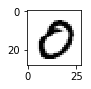

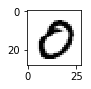

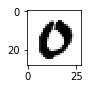

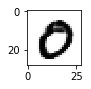

In [71]:
net_auto = AutoCodeNet()
net_auto.load_state_dict(torch.load('model_autoEncode_para.pt'))
net_auto.cuda()
net_auto.eval()


inputs1,inputs2,inputs3 = Variable(torch.from_numpy( train_positive[4:5]).float()).cuda(), \
    Variable(torch.from_numpy( X_train_nor[y_train==9][203:204]).float()).cuda(),\
    Variable(torch.from_numpy( X_train_nor[y_train==9][511:512]).float()).cuda(),
#     outputs = net_auto(inputs)
#     img_show(np.squeeze(outputs.data))
    
middle1 = net_auto.decodeForward(inputs1)
middle2 = net_auto.decodeForward(inputs2)
middle3 = net_auto.decodeForward(inputs3)
# print(middle1.size())
# print(middle1.data[0][2])
# print(middle2.data[0][0])
# imgs_show(np.squeeze(middle1.data),4,6)
# imgs_show(np.squeeze(middle2.data),4,6)
# imgs_show(np.squeeze(middle3.data),4,6)
middle_divide = middle2[:,:,:,:] - middle3[:,:,:,:]
print('negavite middle sum:',torch.sum(middle_divide))
    
middle1[:,:,:,:] = middle1[:,:,:,:]  - 0.4 * middle_divide
    
# print(middle1.data[:,2,:,:])
# print(middle2.data[:,0,:,:])

out = net_auto.encodeforward(middle1)
print(out.size())
# print('out.data = ',out.data)

img_show(np.squeeze(inputs2.data))
img_show(np.squeeze(inputs1.data))
img_show(np.squeeze(inputs3.data))

img_show(np.squeeze(out.data))
# img_show_norm(np.squeeze(out.cpu().data.numpy()))

